# Projet Python pour le data scientist : Prévision des prix des Airbnb
#### Réalisé par M.Blazevic, E.Bordais, C.Nadler, C.Voisin

## 0. Import modules et base de données

In [ ]:
%pip install shap
%pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from string import ascii_letters
import itertools
import collections
import nltk
from nltk.corpus import stopwords 
import warnings
import geopy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import sklearn
import pickle
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import shap


%matplotlib inline


In [ ]:

data = pd.read_csv('airbnb-listings3.csv' , sep=';', low_memory= False)
data

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,7713011,https://www.airbnb.com/rooms/7713011,20170404145355,2017-04-06,STUDIO PIGALLE W BALCONY,"In the heart of Montmarte Pigalle, this lovely...",This newly refurbished flat is ideal for a cou...,"In the heart of Montmarte Pigalle, this lovely...",none,It is central enough for you to walk your way ...,...,9.0,8.0,9.0,NaN,Paris,strict,7,1.84,"48.88292573377615,2.3358125139068453","Host Has Profile Pic,Host Identity Verified,Is..."
1,3335054,https://www.airbnb.com/rooms/3335054,20170404145355,2017-04-05,Montmartre au pied du Sacré-Coeur !,"Ce studio de 22m2, rénové et équipé avec soin,...",A studio where it is very pleasant to settle i...,A studio where it is very pleasant to settle i...,none,The apartment is located rue d'Orsel just belo...,...,10.0,10.0,10.0,NaN,Paris,moderate,1,0.03,"48.88301302713629,2.343468625865973","Host Has Profile Pic,Host Identity Verified,Is..."
2,10066518,https://www.airbnb.com/rooms/10066518,20170404145355,2017-04-06,LOVELY FLAT MONTMARTRE SACRE COEUR,In 2' by walk of the Sacré-Coeur and the Mouli...,Charmant appartement typiquement parisien avec...,In 2' by walk of the Sacré-Coeur and the Mouli...,none,"Situé en plein quartier Montmartre, vous serez...",...,10.0,10.0,10.0,NaN,Paris,moderate,2,0.89,"48.884043258037266,2.3406044314802927","Host Has Profile Pic,Host Identity Verified,Is..."
3,8100080,https://www.airbnb.com/rooms/8100080,20170404145355,2017-04-06,Appartement au pied de Montmartre,"Dans un appartement de 50m², à deux minutes du...",NaN,"Dans un appartement de 50m², à deux minutes du...",none,NaN,...,10.0,10.0,9.0,NaN,Paris,flexible,1,0.17,"48.88519518071742,2.3451007362886185","Host Has Profile Pic,Host Identity Verified,Is..."
4,7397323,https://www.airbnb.com/rooms/7397323,20170404145355,2017-04-06,Beautiful and Spacious Studio,Grd studio lumineux de 32m² avec une grande pi...,NaN,Grd studio lumineux de 32m² avec une grande pi...,none,NaN,...,10.0,8.0,10.0,NaN,Paris,flexible,1,0.11,"48.89480043872107,2.3300554723388434",Host Has Profile Pic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54508,2610162,https://www.airbnb.com/rooms/2610162,20170404145355,2017-04-06,Rue Cler at 500m from Eiffel Tower!,"Logement très calme, ensoleillé, situé derrièr...",Ce logement se trouve au 2e étage et comporte ...,"Logement très calme, ensoleillé, situé derrièr...",none,"Quartier ""vivant"" aussi bien de jour comme de ...",...,9.0,10.0,9.0,NaN,Paris,moderate,1,1.06,"48.858121148036595,2.3060024345958587","Host Has Profile Pic,Host Identity Verified,Is..."
54509,13760682,https://www.airbnb.com/rooms/13760682,20170404145355,2017-04-06,Elegant 160m Home in the heart of St Germain,Our home is in the heart to Saint-Germain-des-...,Our home is a large (160m) classic French apar...,Our home is in the heart to Saint-Germain-des-...,none,St Germain des Pres is the heart of left bank ...,...,10.0,10.0,9.0,NaN,Paris,strict,2,0.56,"48.85289626976821,2.3256957697321123","Host Has Profile Pic,Host Identity Verified,Is..."
54510,9173969,https://www.airbnb.com/rooms/9173969,20170404145355,2017-04-06,partner service test listing3,this is a test summary,NaN,this is a test summary,none,NaN,...,NaN,NaN,NaN,NaN,Paris,flexible,1,NaN,"48.8528110291481,2.3248405116672988","Host Has Profile Pic,Is Location Exact"
54511,13754942,https://www.airbnb.com/rooms/13754942,20170404145355,2017-04-06,2 bedroom appartement in a premium area,Situated in a prestigious area near the Rodin ...,NaN,Situated in a prestigious area near the Rodin ...,none,Premium neighborhoods with many wonderful cafe...,...,10.0,10.0,10.0,NaN,Paris,strict,1,0.34,"48.858549434544635,2.3167999983004584","Host Has Profil

On supprime les features qui ne sont pas utiles

In [16]:
df = data.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Summary', 
              'Experiences Offered', 'Thumbnail Url', 'House Rules', 'Medium Url',
              'Picture Url', 'XL Picture Url', 'Host URL', 'Host Location', 
              'Host About', 'Host Acceptance Rate', 'Host Thumbnail Url', 
              'Host Picture Url', 'Host Neighbourhood', 'Host Listings Count',
               'Host Verifications','Neighbourhood Group Cleansed', 'State', 
                'Market', 'Smart Location', 'Country Code', 'Country', 
               'Calendar last Scraped', 'First Review', 'Last Review', 
                'Jurisdiction Names', 'Features', 'License', 'Interaction', 'Host Name',
                'Monthly Price', 'Weekly Price'
               ], axis=1)

In [17]:
df.head()

,Name,Space,Description,Neighborhood Overview,Notes,Transit,Access,Host ID,Host Since,Host Response Time,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation
0,STUDIO PIGALLE W BALCONY,This newly refurbished flat is ideal for a cou...,"In the heart of Montmarte Pigalle, this lovely...",It is central enough for you to walk your way ...,"Real globetrotters, we are real Parisians with...",The flat is ideally located in Montmartre Piga...,"Subway stations: Abbesses or Pigalle. Bus, Tax...",32492446,2015-05-03,within an hour,...,9.0,9.0,9.0,9.0,8.0,9.0,strict,7,1.84,"48.88292573377615,2.3358125139068453"
1,Montmartre au pied du Sacré-Coeur !,A studio where it is very pleasant to settle i...,A studio where it is very pleasant to settle i...,The apartment is located rue d'Orsel just belo...,The building has a digital code and intercom. ...,The studio is easily accessible. At the foot o...,"The kitchen is equipped with a refrigerator, t...",2726446,2012-06-24,NaN,...,10.0,10.0,10.0,10.0,10.0,10.0,moderate,1,0.03,"48.88301302713629,2.343468625865973"
2,LOVELY FLAT MONTMARTRE SACRE COEUR,Charmant appartement typiquement parisien avec...,In 2' by walk of the Sacré-Coeur and the Mouli...,"Situé en plein quartier Montmartre, vous serez...","Situé en plein quartier Montmartre, vous serez...",Très bien desservi par les transports en commu...,NaN,30432969,2015-04-01,within a few hours,...,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2,0.89,"48.884043258037266,2.3406044314802927"
3,Appartement au pied de Montmartre,NaN,"Dans un appartement de 50m², à deux minutes du...",NaN,NaN,NaN,NaN,42773335,2015-08-28,within a few hours,...,10.0,10.0,10.0,10.0,10.0,9.0,flexible,1,0.17,"48.88519518071742,2.3451007362886185"
4,Beautiful and Spacious Studio,NaN,Grd studio lumineux de 32m² avec une grande pi...,NaN,NaN,NaN,NaN,38757332,2015-07-17,within an hour,...,10.0,9.0,9.0,10.0,8.0,10.0,flexible,1,0.11,"48.89480043872107,2.3300554723388434"


On a donc maintenant 55 features

In [18]:
df.columns

Index(['Name', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
       'Transit', 'Access', 'Host ID', 'Host Since', 'Host Response Time',
       'Host Response Rate', 'Host Total Listings Count', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed', 'City', 'Zipcode',
       'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities', 'Square Feet',
       'Price', 'Security Deposit', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Has Availability', 'Availability 30', 'Availability 60',
       'Availability 90', 'Availability 365', 'Number of Reviews',
       'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Cancellation Policy',
       'Calculated host listings count',

## 1. Statistiques descriptives de la base de données 

### 1.0 Premières statistiques

In [19]:
#On abandonne les colonnes où les prix sont nuls pour éviter de fausser l'analyse
df=df[df['Price']!=0]

In [20]:
df['Price'].describe()

count    54458.000000
mean        94.789159
std         73.357259
min          8.000000
25%         55.000000
50%         75.000000
75%        107.000000
max        999.000000
Name: Price, dtype: float64

On remarque que le prix moyen par nuit est de 94€, avec un prix minimal de 8€, qui paraît assez incohérent avec les tarifs habituels.

Traçons la répartition des prix des Airbnb parisiens

Text(0, 0.5, 'Quantité')

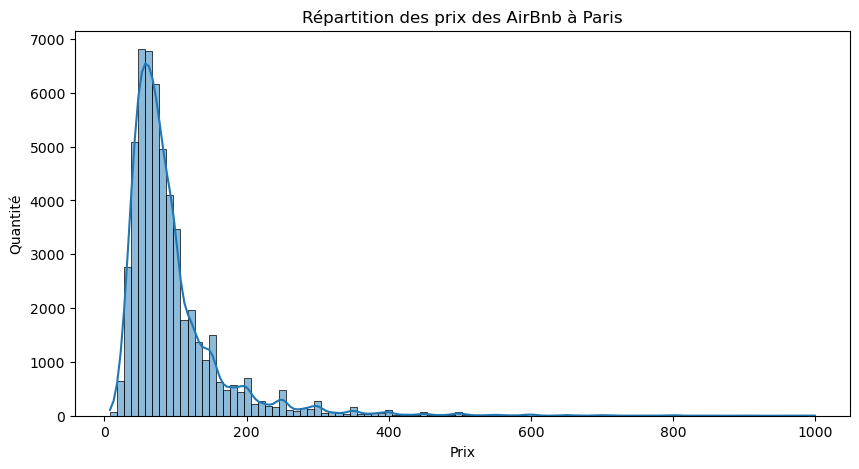

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df['Price'], kde=True, bins=int(100))
plt.title ('Répartition des prix des AirBnb à Paris')
plt.xlabel('Prix')
plt.ylabel('Quantité')

In [22]:
#Pourcentage des airbnb ayant un prix inférieur à 200€
len(df.loc[df['Price']<200])/len(df) * 100

93.09142941003815

On observe que la plus grande partie (environ 93%) des AirBnb ont un prix inférieur à 200€ par nuit.  Traçons désormais les distributions de prix en dessous et au dessus de ce seuil. 

Text(0.5, 1.0, 'Distribution des prix supérieurs à 200 euros')

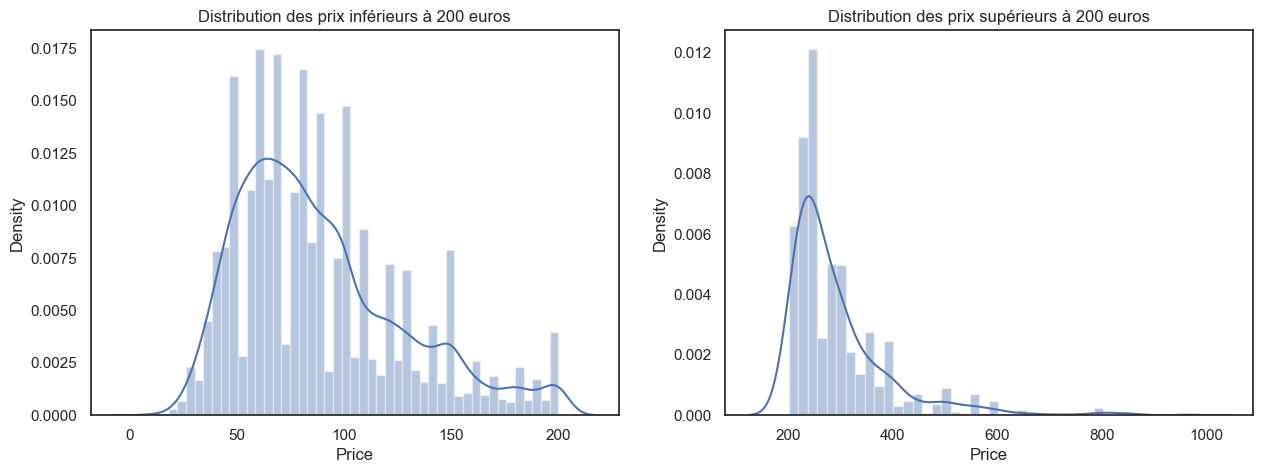

In [190]:
warnings.simplefilter('ignore')

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

ax0 = sns.distplot(df[df['Price'] <= 200]['Price'], ax=axs[0])
ax0.set_title('Distribution des prix inférieurs à 200 euros')

ax1 = sns.distplot(df[df['Price'] > 200]['Price'], ax=axs[1])
ax1.set_title('Distribution des prix supérieurs à 200 euros')

Qu'est ce qui influence le plus le prix d'un Airbnb ? 
Nous avons naturellement pensé à plusieurs axes tels que : 
- sa taille : nombre de chambres, de personnes qu'il peut accueillir, superficie
- sa localisation : quartier 
- qualité de l'hébergement : matériel et services disponibles
- qualité de l'hôte


##### Quelles sont les variables les plus corrélées au prix ?

In [24]:
#on ne garde que les variables numériques
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,Host ID,Host Response Rate,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,...,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month
0,32492446,100.0,7.0,48.882926,2.335813,2,1.0,0.0,1.0,NaN,...,37,85.0,9.0,9.0,9.0,9.0,8.0,9.0,7,1.84
1,2726446,NaN,1.0,48.883013,2.343469,2,1.0,0.0,1.0,NaN,...,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0.03
2,30432969,95.0,2.0,48.884043,2.340604,2,1.0,1.0,1.0,NaN,...,13,97.0,10.0,10.0,10.0,10.0,10.0,10.0,2,0.89
3,42773335,100.0,1.0,48.885195,2.345101,2,1.0,1.0,1.0,NaN,...,3,87.0,10.0,10.0,10.0,10.0,10.0,9.0,1,0.17
4,38757332,100.0,1.0,48.894800,2.330055,2,1.0,0.0,1.0,NaN,...,2,90.0,10.0,9.0,9.0,10.0,8.0,10.0,1,0.11


<AxesSubplot:>

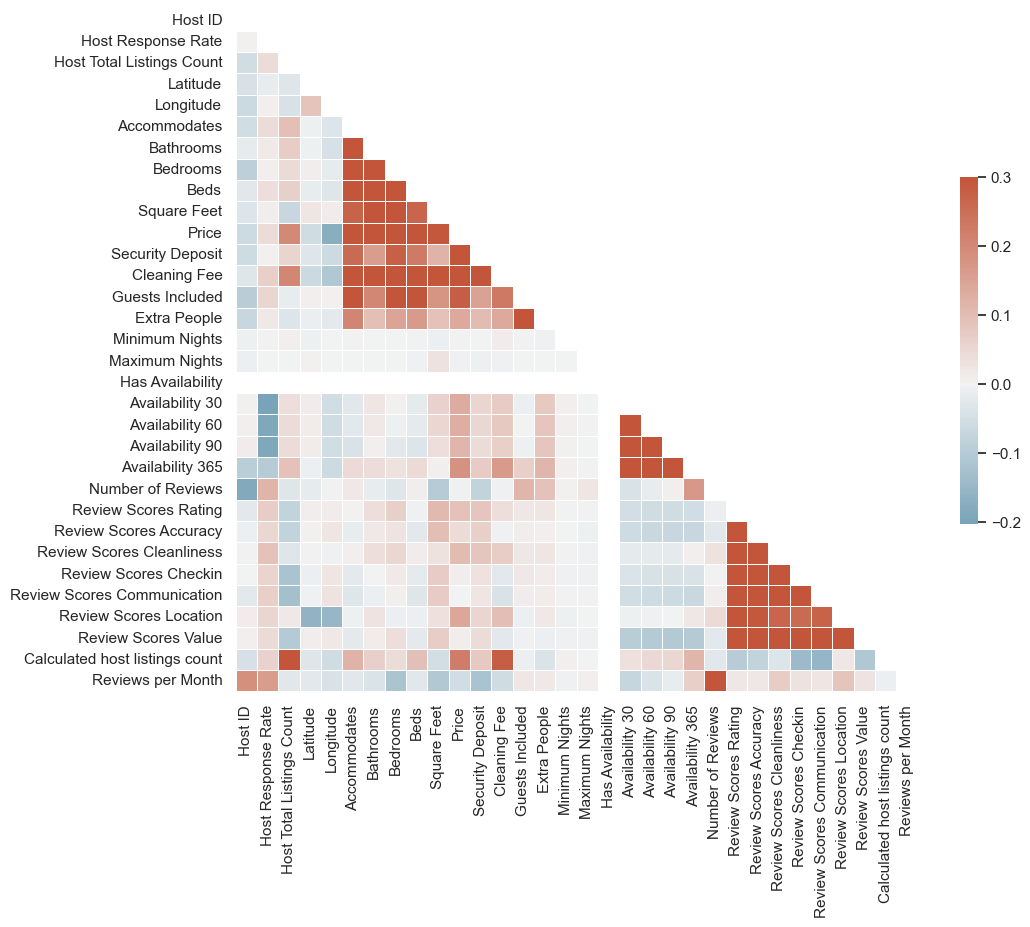

In [25]:
sns.set_theme(style="white")

# Matrice de corrélation
corr = df_num.corr()

# Génération d'un masque pour la partie supérieure du triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mise en place de la figure
f, ax = plt.subplots(figsize=(11, 9))

# Création d'une palette de couleurs
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Tracé de la heatmap avec le masque et les bonnes dimensions
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
#Variables numériques les plus corrélées avec le prix

var_corr = df_num.corr()['Price']
var = var_corr[abs(var_corr) > 0.2].sort_values(ascending=False)
print("Voici les {} variables les plus fortement corrélées avec le prix par nuit (en ignorant la variable 'Price'):\n{}".format(len(var), var))

Voici les 10 variables les plus fortement corrélées avec le prix par nuit (en ignorant la variable 'Price'):
Price                             1.000000
Cleaning Fee                      0.606410
Accommodates                      0.578680
Bedrooms                          0.548549
Beds                              0.506751
Bathrooms                         0.465715
Security Deposit                  0.375173
Square Feet                       0.293823
Guests Included                   0.281018
Calculated host listings count    0.222991
Name: Price, dtype: float64


Ainsi, les variables les plus corrélées au prix sont les frais de nettoyage, la capacité d'accueil, le nombre de chambres, de lits et de salles de bain, la caution, la superficie de l'appartement, le nombre d'invités inclus dans l'annonce de base, le nombre d'annonces de l'hôte, ainsi que l'arrondissement.

### 1.1 Influence de la localisation

In [27]:
df.columns

Index(['Name', 'Space', 'Description', 'Neighborhood Overview', 'Notes',
       'Transit', 'Access', 'Host ID', 'Host Since', 'Host Response Time',
       'Host Response Rate', 'Host Total Listings Count', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed', 'City', 'Zipcode',
       'Latitude', 'Longitude', 'Property Type', 'Room Type', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Amenities', 'Square Feet',
       'Price', 'Security Deposit', 'Cleaning Fee', 'Guests Included',
       'Extra People', 'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Has Availability', 'Availability 30', 'Availability 60',
       'Availability 90', 'Availability 365', 'Number of Reviews',
       'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Cancellation Policy',
       'Calculated host listings count',

Après une rapide analyse, on se rend compte que la variable Neighbourhood Cleansed est moins précise que Neighbourhood
(20 valeurs contre 64) mais elle semble éliminer certaines erreurs et doublons (par exemple, le quartier Cannesqui qui n'existe pas, le 15ème arrondissement qui groupe avec d'autre quartiers...). On utilisera donc cette variable là. 

In [28]:
df['Neighbourhood Cleansed'].describe()

count                 54512
unique                   20
top       Buttes-Montmartre
freq                   6315
Name: Neighbourhood Cleansed, dtype: object

In [29]:
#On produit un tableau qui indique le nombre et le prix moyen des Airbnb par quartier
df_nb = df.groupby('Neighbourhood Cleansed').agg({'Neighbourhood Cleansed':'count', 'Price':'mean'})
df_nb.columns = ['count', 'mean_price']
df_nb.reset_index(inplace=True)
df_nb.sort_values('count', ascending=False, ignore_index=True, inplace=True)

In [30]:
df_nb

,Neighbourhood Cleansed,count,mean_price
0,Buttes-Montmartre,6315,74.813243
1,Popincourt,5381,79.487546
2,Vaugirard,4000,90.633567
3,Entrepôt,3749,82.779616
4,Batignolles-Monceau,3547,88.391819
5,Ménilmontant,2981,65.175444
6,Buttes-Chaumont,2951,66.420285
7,Passy,2895,123.859570
8,Opéra,2391,98.421757
9,Temple,2368,120.041807


On s'aperçoit donc que les prix varient fortement entre les différents quartiers de Paris. On s'intéresse désormais au prix par arrondissement, pour ensuite faire de la visualisation sur carte. 

In [31]:
#Toutes les valeurs prises par la variable Zipcode
df['Zipcode'].unique()

array(['75018', '75004', '75003', '75017', nan, '75019', '75020', '75007',
       '75015', '75006', '75010', '75009', '93300', '75012', '75011',
       '75008', '75013', '75005', '75002', '75001', '75014', '75116',
       '75016', '750018', '92130', '75', '75011\r\n75011', 'Paris 75004',
       '92300', '75000', '94250', '94160', '76016', '75011 PARIS',
       '92100', '750109', '7015', '92240', '92200', 'adf', 'Paris',
       '700014', '75 018', '93310', '75014\r\n75014', 'Montmartre',
       '750016', '075016', '93170', '75003\r\n75003', '78005', '78008',
       '75018e', '75106', '92170'], dtype=object)

On remarque que il y a beaucoup d'imperfections sur cette variable, il faut donc la nettoyer : 
- enlever les Airbnb situés en banlieue (zipcode commencant par 92, 94, ...) 
- regrouper les 75018.0 et 75018 

In [32]:
#on créé la variable arrondissement, on lui donne la valeur 0 par défaut
df['Arrondissement']=0

In [33]:
#on attribue la bonne valeur à la variable arrondissement

df.loc[df["Zipcode"]=="75001", "Arrondissement"] = 1
df.loc[df["Zipcode"]=="75001.0", "Arrondissement"] = 1
df.loc[df["Zipcode"]=="75002", "Arrondissement"] = 2
df.loc[df["Zipcode"]=="75002.0", "Arrondissement"] = 1
df.loc[df["Zipcode"]=="75003", "Arrondissement"] = 3
df.loc[df["Zipcode"]=="75003.0", "Arrondissement"] = 3
df.loc[df["Zipcode"]=="75004", "Arrondissement"] = 4
df.loc[df["Zipcode"]=="75004.0", "Arrondissement"] = 4
df.loc[df["Zipcode"]=="75005", "Arrondissement"] = 5
df.loc[df["Zipcode"]=="75005.0", "Arrondissement"] = 5
df.loc[df["Zipcode"]=="75006", "Arrondissement"] = 6
df.loc[df["Zipcode"]=="75006.0", "Arrondissement"] = 6
df.loc[df["Zipcode"]=="75007", "Arrondissement"] = 7
df.loc[df["Zipcode"]=="75007.0", "Arrondissement"] = 7
df.loc[df["Zipcode"]=="75008", "Arrondissement"] = 8
df.loc[df["Zipcode"]=="75008.0", "Arrondissement"] = 8
df.loc[df["Zipcode"]=="75009", "Arrondissement"] = 9
df.loc[df["Zipcode"]=="75009.0", "Arrondissement"] = 9
df.loc[df["Zipcode"]=="75010", "Arrondissement"] = 10
df.loc[df["Zipcode"]=="75010.0", "Arrondissement"] = 10
df.loc[df["Zipcode"]=="75011", "Arrondissement"] = 11
df.loc[df["Zipcode"]=="75011.0", "Arrondissement"] = 11
df.loc[df["Zipcode"]=="75012", "Arrondissement"] = 12
df.loc[df["Zipcode"]=="75012.0", "Arrondissement"] = 12
df.loc[df["Zipcode"]=="75013", "Arrondissement"] = 13
df.loc[df["Zipcode"]=="75013.0", "Arrondissement"] = 13
df.loc[df["Zipcode"]=="75014", "Arrondissement"] = 14
df.loc[df["Zipcode"]=="75014.0", "Arrondissement"] = 14
df.loc[df["Zipcode"]=="75015", "Arrondissement"] = 15
df.loc[df["Zipcode"]=="75015.0", "Arrondissement"] = 15
df.loc[df["Zipcode"]=="75016", "Arrondissement"] = 16
df.loc[df["Zipcode"]=="75016.0", "Arrondissement"] = 16      
df.loc[df["Zipcode"]=="75116", "Arrondissement"] = 16
df.loc[df["Zipcode"]=="75116.0", "Arrondissement"] = 16               
df.loc[df["Zipcode"]=="75017", "Arrondissement"] = 17
df.loc[df["Zipcode"]=="75017.0", "Arrondissement"] = 17           
df.loc[df["Zipcode"]=="75018", "Arrondissement"] = 18
df.loc[df["Zipcode"]=="75018.0", "Arrondissement"] = 18    
df.loc[df["Zipcode"]=="75019", "Arrondissement"] = 19
df.loc[df["Zipcode"]=="75019.0", "Arrondissement"] = 19   
df.loc[df["Zipcode"]=="75020", "Arrondissement"] = 20
df.loc[df["Zipcode"]=="75020.0", "Arrondissement"] = 20 

In [34]:
df['Arrondissement'].unique()

array([18,  4,  3, 17,  0, 19, 20,  7, 15,  6, 10,  9, 12, 11,  8, 13,  5,
        2,  1, 14, 16], dtype=int64)

In [35]:
#on enlève tous les Airbnb qui n'ont pas été affectés à une valeur
df = df[df['Arrondissement']> 0]

Commentaire : on avait auparavant 54513 lignes dans le dataframe, on en a désormais 53731, on a donc perdu 800 données en nettoyant la variable liée aux arrondissements. Cette perte n'est pas significative. 

In [152]:
#On affiche le nombre d'airbnb et le prix moyen des airbnb par arrondissement
df_arr = df.groupby('Arrondissement').agg({'Arrondissement':'count', 'Price':'mean'})
df_arr.columns = ['Count', 'Mean_price']
df_arr.reset_index(inplace=True)
df_arr.sort_values('Mean_price', ascending=False, ignore_index=True, inplace=True)

In [153]:
df_arr.head()

,Arrondissement,Count,Mean_price
0,8,465,142.965591
1,1,487,139.406571
2,7,583,139.268041
3,6,736,136.648098
4,4,808,127.225248


On remarque que les arrondissements les plus chers de Paris sont le 8e, le 6e et le 1er. 

### 1.2 Disponbilité

Text(0, 0.5, 'Nombre')

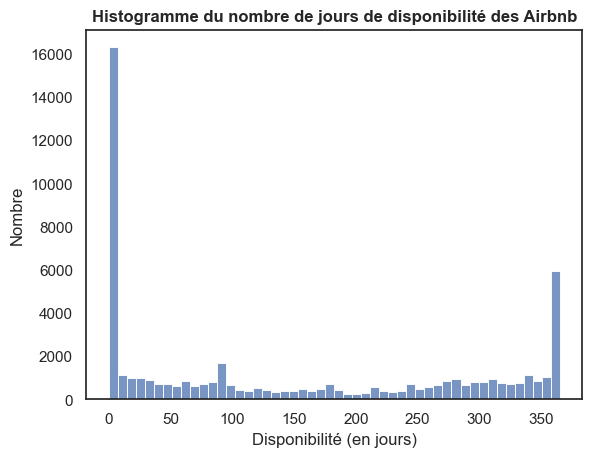

In [38]:
sns.histplot(data=df["Availability 365"],bins=int(50))
plt.title('Histogramme du nombre de jours de disponibilité des Airbnb', weight='bold')
plt.xlabel('Disponibilité (en jours)')
plt.ylabel('Nombre')

In [39]:
a = len(df[df['Availability 365']>300])
b = len(df[df['Availability 365']<60])
c = len(df[df['Availability 365']==0])
a,b,c

(12735, 22374, 14516)

On remarque que près de la moitié des Airbnb sont loués moins de 60 jours par an, ce qui semble correspondre au concept de base de Airbnb - c'est à dire louer sa maison ou son appartement quand on est en vacances ou autre pour arrondir ses fins de mois. 
Cependant, on voit aussi que plus de 12 000 Airbnb sont loués plus de 300 jours par an. On observe donc que certaines personnes louent quasiment en continuité leur logement sur Airbnb pour de courtes périodes, alors qu'ils pourraient le louer sur des longues durées. On peut donc supposer qu'il est plus intéressant financièrement de louer son bien sur Airbnb que en agence par exemple.

### 1.3 Influence de la taille du logement

On a vu dans la matrice de corrélation que la "taille" du logement était fortement corrélée au prix ce qui semble logique. On peut faire quelques statistiques descriptives pour avoir un aperçu des différentes tailles de logement. 

In [40]:
#On enlève les valeurs manquantes au niveau du nombre de salles de bain
df = df[df['Bathrooms'].notnull()]

Dans la partie modélisation, nous continuerons à enlever les lignes où il n'y a pas de données à propos du nombre de chambres, de lits, des frais de nettoyage, du dépôt de sécurité... Nous ne le faisons pas maintenant car cela ne laisse qu'environ 19000 lignes, et enlève des données essentielles pour l'analyse des reviews menée en partie 1.4.

In [41]:
#Nouveau data frame uniquement avec les airbnb où le nb de metres carrés est renseigné
df_feet = df.loc[(df['Square Feet'] !=0)]
len(df_feet)

52977

Text(0, 0.5, 'Quantité')

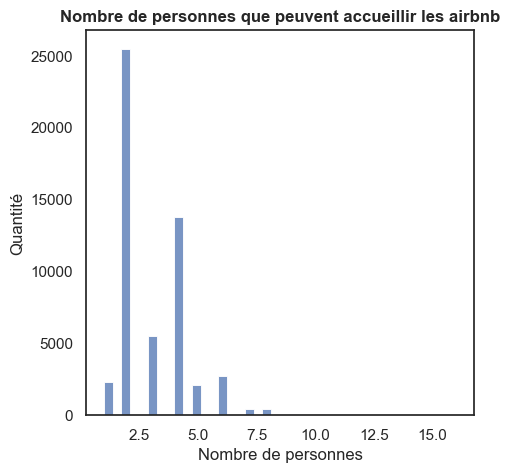

In [42]:
#Répartition du nombres de personnes que peuvent accueillir les Airbnb, pour savoir à quels types de logement on traite
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(df_feet['Accommodates'], bins=int(40))
plt.title ('Nombre de personnes que peuvent accueillir les airbnb', weight='bold')
plt.xlabel('Nombre de personnes')
plt.ylabel('Quantité')


La majorité des Airbnb accueillent 2 ou 4 personnes.

In [43]:
df_feet['Square Feet'].describe()

count     1482.000000
mean       544.098516
std        654.072407
min         11.000000
25%        291.000000
50%        431.000000
75%        646.000000
max      15059.000000
Name: Square Feet, dtype: float64

Commentaire : 
- il manque énormément de données sur les superficies : sur plus de 50 000 données à la base, on en a à peine 1500
- Le maximum de surface est de 15000 square feet ce qui correspond à 1393m2, probablement un erreur de saisie donc on va enlever tous les logements ayant une superficie supérieure à 2500 square feet (soit 232m2).

In [44]:
df_feet = df_feet.loc[(df_feet['Square Feet'] < 2500)]

Text(0, 0.5, 'Surface (en m2)')

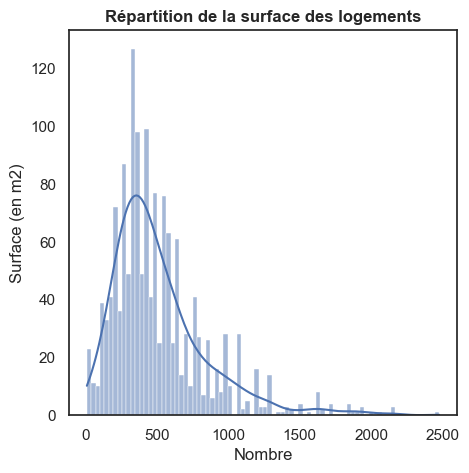

In [45]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=df_feet['Square Feet'], kde=True, bins=int(80))
plt.title ('Répartition de la surface des logements', weight='bold')
plt.xlabel('Nombre')
plt.ylabel('Surface (en m2)')

A cause du nombre très important de données manquantes sur les surfaces des logements, on va désormais s'intéresser au nombre de chambres, de salles de bains, etc... qui sont également des bons indicateurs de la taille du logement.


In [46]:
df['Bathrooms'] = df['Bathrooms'].astype(int)

In [47]:
df['Bathrooms'].unique()

array([1, 0, 3, 2, 4, 6, 7, 5, 8])

In [48]:
df['Bedrooms'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan,  7.,  6., 10.,  8.])

In [49]:
df_bed = df.groupby('Bedrooms').agg({'Bedrooms':'count'})
df_bed.columns = ['count']
df_bed.reset_index(inplace=True)
df_bed.sort_values('count', ascending=False, ignore_index=True, inplace=True)
df_bed

,Bedrooms,count
0,1.0,31801
1,0.0,11079
2,2.0,7849
3,3.0,2094
4,4.0,484
5,5.0,91
6,6.0,21
7,7.0,4
8,10.0,2
9,8.0,1


In [50]:
df_bath = df.groupby('Bathrooms').agg({'Bathrooms':'count'})
df_bath.columns = ['count']
df_bath.reset_index(inplace=True)
df_bath.sort_values('count', ascending=False, ignore_index=True, inplace=True)
df_bath

,Bathrooms,count
0,1,49651
1,2,2914
2,0,538
3,3,308
4,4,59
5,6,30
6,5,22
7,7,13
8,8,12


Plus de 11 000 logements n'ont pas de chambre, on peut donc en déduire que ce sont des studios. La plus grande majorité des logements ont une unique salle de bain. 

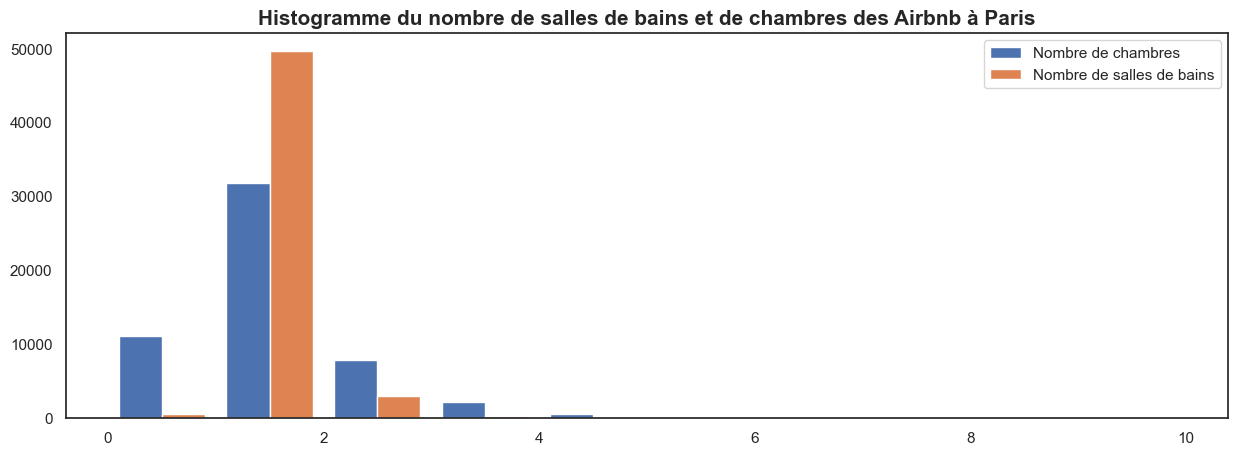

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist([df["Bedrooms"], df["Bathrooms"]], label=['Nombre de chambres', 'Nombre de salles de bains'], edgecolor = 'white')
plt.title("Histogramme du nombre de salles de bains et de chambres des Airbnb à Paris",size=15, weight='bold')
plt.legend()


### 1.4 Les reviews

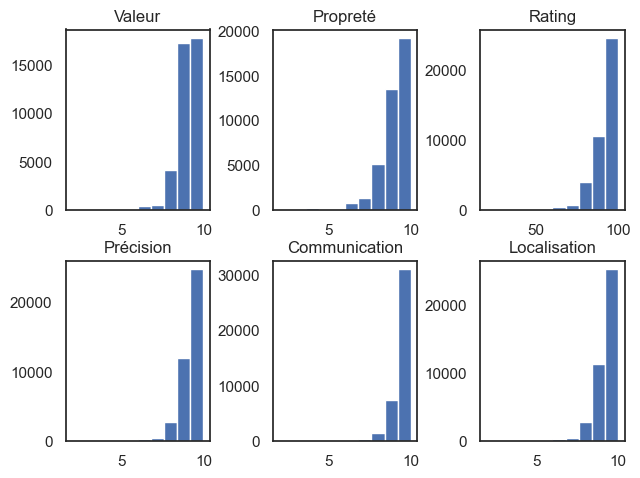

In [52]:

# On regarde la distribution sur les différentes notes données 

fig, ax = plt.subplots(2, 3)
fig.tight_layout()

ax[0, 0].hist(data["Review Scores Value"]) #row=0, col=0
ax[0, 0].set_title('Valeur')
ax[1, 0].hist(data["Review Scores Accuracy"]) #row=1, col=0
ax[1, 0].set_title('Précision')
ax[0, 1].hist(data["Review Scores Cleanliness"]) #row=0, col=1
ax[0, 1].set_title('Propreté')
ax[1, 1].hist(data["Review Scores Communication"]) #row=1, col=1
ax[1, 1].set_title('Communication')
ax[1, 2].hist(data["Review Scores Location"]) #row=1, col=2
ax[1, 2].set_title('Localisation')
ax[0, 2].hist(data["Review Scores Rating"]) #row=2, col=2
ax[0, 2].set_title('Rating')
plt.show()

In [53]:
#On regarde le nombre d'offres qui n'ont pas de description 
data['Description'].isnull().sum()

7

In [54]:
# Si on ne veut pas fausser l'analyse textuelle et avoir un message d'erreur, il faut enlever les lignes qui correspondent à des valeur manquantes 
def transform(lst) :
  return ([i for item in lst for i in item.lower().split()])
full_reviews = transform(data['Description'].fillna(""))

On peut maintenant s'intéresser à la fréquence des mots sur les descriptions d'appartements, dans le but de regarder le lien potentiel avec les prix des Airbnb


In [55]:

# Fréquence de mots

nb_mots = collections.Counter(full_reviews) 

frq_mots = pd.DataFrame(nb_mots.most_common(8),
                             columns=['mots', 'occurences'])

frq_mots.head()


,mots,occurences
0,the,234341
1,and,167659
2,a,159574
3,de,139466
4,et,92759


On obtient un résultat peu étonnant : les mots qui reviennent le plus sont des mots de liaison, des déterminants ou des conjonctions de coordination (« et »). 
Cependant, ces mots ne vont pas nous être utiles pour faire de l'analyse textuelle sur la qualité des descriptions. 
On va donc essayer d'enlever ces « stopwords », via la méthode vue en cours. 

In [56]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words(['french','english']))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ac3e2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ac3e2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
# On ajoute des stop words à la liste initiale, qui était mal configurée 

new_stopwords = ['1', 'one', '2', 'two', 'deux', '3','4','5', '10', '-', ':', ',', 'tout', '!', '.', "d'un", 'rue', 'pied', 'min', 'also', 'Paris', 'paris', 'paris.','paris,', 'parisian', 'place', 'flat', 'floor', 'room', 'bed', 'lit', 'chambre', 'situé', 'logement', 'salle', 'appartement', "l'appartement", 'apartment', 'minutes', 'métro', 'metro', 'studio','kitchen']
new_stopwords_list = stop_words.union(new_stopwords)

print(new_stopwords_list)


{'seront', 'myself', "couldn't", 'paris', 'against', 've', 'when', 'of', 'min', 'was', 'after', 'pour', 'are', 'have', 'same', "that'll", 'weren', 'been', '-', 'eu', 'votre', 'avec', 'their', 'both', 'eus', 'même', 'nous', 'who', 'eûmes', "shan't", 'à', 'itself', 'ayons', 'aurait', 'avais', 'out', 'du', 'mightn', 'auriez', 'apartment', 'eût', 'logement', 'aurai', "it's", 'ils', 'wouldn', 'soit', 'fussions', 'our', 'off', 'm', 'de', "you'll", 'own', 'hasn', 'haven', 'room', 'doesn', 'au', 'or', 'étant', 'soyons', 'se', 'ou', 'also', "don't", 'mais', 'vous', 'sois', 'avons', 'aurais', 'étée', 'does', 'is', 'were', 'fusse', '5', 'yours', 'hers', 'furent', 'ait', 'soient', 'ne', '4', 'aux', 'lui', 'eue', 'so', 'if', 'kitchen', 'et', 'métro', "isn't", 'serai', 'shan', 'whom', 'studio', 'below', 'again', 'fûtes', 'floor', 'que', 'été', 'avez', 'we', 'because', 'avaient', 'y', 'its', 'and', 'êtes', 'a', 'étaient', 'some', 'them', 'son', 'étante', 'un', 'étais', "you're", 'i', 'tout', 'being',

In [58]:

mots_listing = [word for word in full_reviews if word not in new_stopwords_list]
nb_mots_listing = collections.Counter(mots_listing)
nb_mots_listing_df = pd.DataFrame(nb_mots_listing.most_common(33),
                             columns=['words', 'count'])

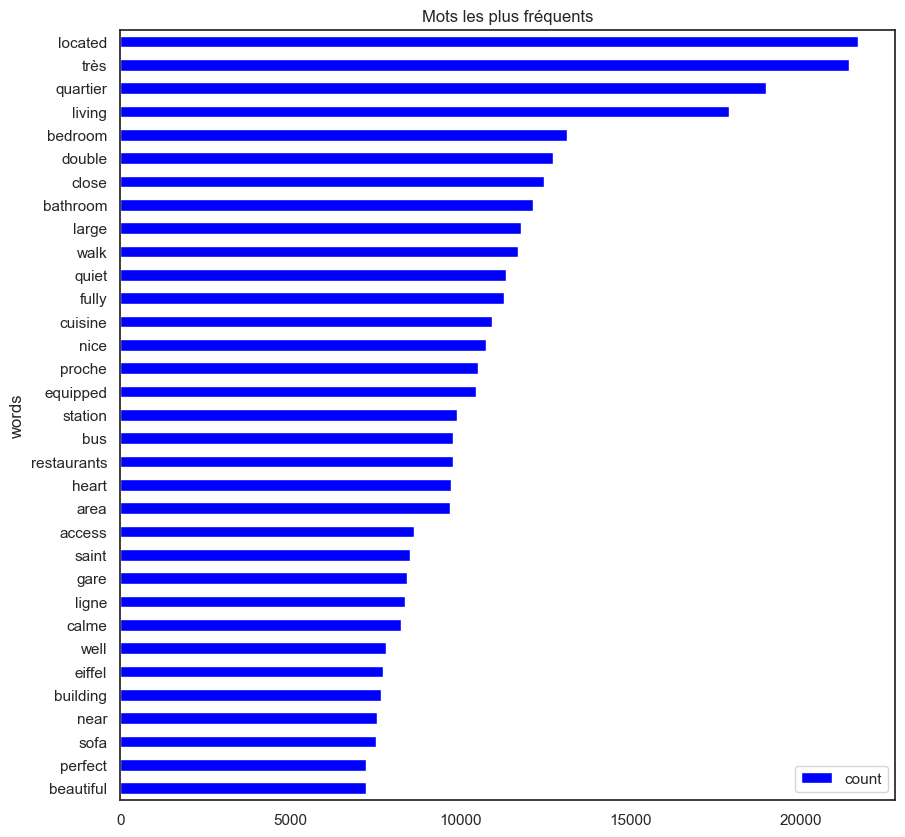

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))

nb_mots_listing_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="blue")

ax.set_title("Mots les plus fréquents")

plt.show()


In [60]:
# Pour essayer de faire un nuage de mots ####continue d'essayer nadler, beliaive crois en tes rêves


#conda install -c conda-forge wordcloud



## Modélisation

Puisque les biens traités sont tous uniques, une valeur manquante concernant certaines variables (prix, du nombre de personnes accueillies, dépôt de sécurité...) ne peut pas être remplacée par une valeur moyenne ou médiane ("imputing"). On décide de supprimer les lignes si l'une des variables suivantes est manquante.

In [61]:
df.isnull().sum()

Name                                  3
Space                             16185
Description                           7
Neighborhood Overview             21289
Notes                             36296
Transit                           19009
Access                            26061
Host ID                               0
Host Since                           11
Host Response Time                17743
Host Response Rate                17743
Host Total Listings Count            11
Street                                0
Neighbourhood                      6827
Neighbourhood Cleansed                0
City                                  0
Zipcode                               0
Latitude                              0
Longitude                             0
Property Type                         0
Room Type                             0
Accommodates                          0
Bathrooms                             0
Bedrooms                            121
Beds                                 22


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53547 entries, 0 to 54512
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Name                            53544 non-null  object 
 1   Space                           37362 non-null  object 
 2   Description                     53540 non-null  object 
 3   Neighborhood Overview           32258 non-null  object 
 4   Notes                           17251 non-null  object 
 5   Transit                         34538 non-null  object 
 6   Access                          27486 non-null  object 
 7   Host ID                         53547 non-null  int64  
 8   Host Since                      53536 non-null  object 
 9   Host Response Time              35804 non-null  object 
 10  Host Response Rate              35804 non-null  float64
 11  Host Total Listings Count       53536 non-null  float64
 12  Street                          

In [63]:
df = df[df['Cleaning Fee'].notnull()]
df = df[df['Security Deposit'].notnull()]

df = df[df['Bedrooms'].notnull()]
df = df[df['Amenities'].notnull()]
df = df[df['Review Scores Rating'].notnull()]
df = df[df['Host Since'].notnull()]
df = df[df['Host Response Time'].notnull()]

In [64]:
df.isnull().sum()

Name                                  0
Space                              2404
Description                           2
Neighborhood Overview              4306
Notes                              8755
Transit                            3713
Access                             5839
Host ID                               0
Host Since                            0
Host Response Time                    0
Host Response Rate                    0
Host Total Listings Count             0
Street                                0
Neighbourhood                      1805
Neighbourhood Cleansed                0
City                                  0
Zipcode                               0
Latitude                              0
Longitude                             0
Property Type                         0
Room Type                             0
Accommodates                          0
Bathrooms                             0
Bedrooms                              0
Beds                                  2


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15508 entries, 0 to 54508
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Name                            15508 non-null  object 
 1   Space                           13104 non-null  object 
 2   Description                     15506 non-null  object 
 3   Neighborhood Overview           11202 non-null  object 
 4   Notes                           6753 non-null   object 
 5   Transit                         11795 non-null  object 
 6   Access                          9669 non-null   object 
 7   Host ID                         15508 non-null  int64  
 8   Host Since                      15508 non-null  object 
 9   Host Response Time              15508 non-null  object 
 10  Host Response Rate              15508 non-null  float64
 11  Host Total Listings Count       15508 non-null  float64
 12  Street                          

Maintenant qu'il n'y a plus de valeurs manquantes pour des colonnes essentielles à notre modèle, nous allons transformer des variables qualitatives en variables quantitatives. Par exemple, la variable "Cancellation Policy" peut jouer un rôle très important dans la réservation d'un Airbnb - on aura plutôt tendance à favoriser un Airbnb avec des conditions d'annulation flexibles en cas d'imprévu.

Après lecture des indications liées aux différents modes d'annulation et de remboursement, on décide d'attribuer un score entre 1 et 5 aux annonces ; 5 correspond à "super_strict60", qui laisse très peu de flexibilité aux clients, et 1 à "flexible", qui permet d'annuler jusqu'à 24h à l'avance sans frais.

Il n'y a aucune annonce correspondant à "super_strict_60", donc tous nos listings auront un score entre 1 et 4. On crée la nouvelle variable, puis on la fait correspondre aux politiques d'annulation.

In [66]:
df["Score Annulation"] = 0

In [67]:
df["Cancellation Policy"].unique()

array(['strict', 'moderate', 'flexible', 'super_strict_30'], dtype=object)

In [68]:
df.loc[df['Cancellation Policy']=='flexible', "Score Annulation"] = 1 
df.loc[df['Cancellation Policy']=='moderate', "Score Annulation"] = 2
df.loc[df['Cancellation Policy']=='strict', "Score Annulation"] = 3
df.loc[df['Cancellation Policy']=='super_strict_30', "Score Annulation"] = 4 

In [69]:
df

,Name,Space,Description,Neighborhood Overview,Notes,Transit,Access,Host ID,Host Since,Host Response Time,...,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Arrondissement,Score Annulation
0,STUDIO PIGALLE W BALCONY,This newly refurbished flat is ideal for a cou...,"In the heart of Montmarte Pigalle, this lovely...",It is central enough for you to walk your way ...,"Real globetrotters, we are real Parisians with...",The flat is ideally located in Montmartre Piga...,"Subway stations: Abbesses or Pigalle. Bus, Tax...",32492446,2015-05-03,within an hour,...,9.0,9.0,8.0,9.0,strict,7,1.84,"48.88292573377615,2.3358125139068453",18,3
8,Montmartre-Metro Abbesses,Quartier bobo (bourgeois-bohème) où se rencont...,Petit logement pour 2 personnes (15m²-161 sq f...,L'appartement se situe à 180 mètres du métro A...,-----Internet free WIFI------ -----Bed linen a...,NaN,NaN,8272773,2013-08-20,within an hour,...,10.0,10.0,10.0,9.0,strict,3,3.35,"48.884574794276794,2.3364623213623235",18,3
16,♥ Exotic Loft Montmartre + terrace !,Welcome to you! - Loft 80m² near Montmartre -...,Exotic loft with a terrace of 35 m² at the foo...,"Nearby you will find many shops for groceries,...","My wife Michelle and I Damien, pay attention t...",There are many bus lines and subway to anywher...,You have access to all the apartment and the t...,2829146,2012-07-04,within a day,...,10.0,10.0,9.0,9.0,strict,1,0.31,"48.88581031428594,2.326678991449712",18,3
19,Cosy flat / Montmartre 10 min walk,The Sacré Coeur and the Abbesses street is 10 ...,"The apartment is ideally located in Paris, at ...",The apartment is very well located for explori...,"Suivant la saison et la durée de votre séjour,...",Located near the Simplon metro station (line 4...,At your disposal guides to Paris with all rele...,12382291,2014-02-19,within an hour,...,10.0,10.0,8.0,10.0,moderate,1,0.72,"48.893635042498,2.3467555434390395",18,2
33,flat to rent these summer,My flat is located in Le marais nearby Place d...,I rent my flat these summer (july and august) ...,"Le Marais is a nice area, full of old building...",- pas d'animaux svp,all transports facilities nearby To get here f...,we share the kitchen and bathroom while I rent...,13022412,2014-03-11,within an hour,...,10.0,10.0,10.0,9.0,moderate,2,1.50,"48.852995466539134,2.36452620127334",4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54500,Cosy studio w/bath - Eiffel Tower,This small apartment has been completely renov...,Charming & quiet place in the historical distr...,NaN,NaN,Metro Line 8 Metro Line 13 Rer station Invalid...,Possibilité parking aux Invalides (20€/jour),13556685,2014-03-26,within an hour,...,10.0,10.0,10.0,10.0,strict,3,2.44,"48.85845196408179,2.308919581602885",7,3
54504,Apt 60 m² balcony Champ de Mars Eiffel Tower,NaN,Charming apt - 60m² - near Champ de Mars - Eif...,NaN,"Domestic equipment : nespresso, fridge, toaste...","Access : metros La Motte Piquet Grenelle (L.8,...","Full access apartment : Living room, bedroom, ...",33176005,2015-05-12,within a day,...,10.0,10.0,10.0,9.0,strict,1,1.13,"48.852114527389666,2.2997429846960387",7,3
54506,"Chic district, B&B.","Nestled in a residential, safe and central are...",This beautiful 160 sq meter apartment is locat...,"Located on the left bank of the Seine, it's on...",You can check-in between 14:00 pm and 22:00 pm...,I'll be happy to inform you about all transpor...,ACCESS Feel confortable to enjoy your snacks i...,19094239,2014-07-29,within an hour,...,10.0,10.0,10.0,10.0,moderate,4,0.96,"48.847333757257786,2.3168425106941846",7,2
54507,Blvd St Germain - Orsay Museum,We are a family of antique dealers and interio...,Cosy and very quiet one bedroom apartment (sle...,The 7th district is one of the most exclusive ...,Our apartment has a king size bed but can be s...,The metro station Rue du Bac (line 12) and th

De même, on crée une variable numérique Réactivité qui correspond à la qualité de "Host Response Time" ; plus l'hôte répond rapidement, plus le score est bas.

In [70]:
df["Reactivite"] = 0

In [71]:
df["Host Response Time"].unique()

array(['within an hour', 'within a day', 'within a few hours',
       'a few days or more'], dtype=object)

In [72]:
df.loc[df['Host Response Time']=='within an hour', "Reactivite"] = 1 
df.loc[df['Host Response Time']=='within a few hours', "Reactivite"] = 2
df.loc[df['Host Response Time']=='within a day', "Reactivite"] = 3
df.loc[df['Host Response Time']=='a few days or more', "Reactivite"] = 4 

Enfin, on crée une variable "Popu Arrondissement" qui correspond au nombre d'annonces par arrondissement ; en effet, cette variable peut influencer le prix d'une annonce et aussi favoriser une réservation par rapport à une autre annonce.

In [73]:
df["Popu Arrondissement"]=0

In [74]:
df['Arrondissement'].unique()

array([18,  4, 17, 19, 15,  7,  9, 10, 12, 11,  8, 13,  6,  5,  1,  3, 20,
        2, 14, 16], dtype=int64)

In [75]:
listepopu = df.groupby(['Arrondissement']).agg({'Arrondissement':'count'})
listepopu


,Arrondissement
Arrondissement,
1,487
2,692
3,887
4,808
5,685
6,736
7,583
8,465
9,656


In [76]:
df['Popu Arrondissement'] = df['Arrondissement'].groupby(df['Arrondissement']).transform('count')

In [77]:
df['Popu Arrondissement'].unique()

array([1577,  808,  885,  580, 1066,  583,  656, 1110,  485, 1494,  465,
        400,  736,  685,  487,  887,  651,  692,  522,  739], dtype=int64)

In [78]:
df

,Name,Space,Description,Neighborhood Overview,Notes,Transit,Access,Host ID,Host Since,Host Response Time,...,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Arrondissement,Score Annulation,Reactivite,Popu Arrondissement
0,STUDIO PIGALLE W BALCONY,This newly refurbished flat is ideal for a cou...,"In the heart of Montmarte Pigalle, this lovely...",It is central enough for you to walk your way ...,"Real globetrotters, we are real Parisians with...",The flat is ideally located in Montmartre Piga...,"Subway stations: Abbesses or Pigalle. Bus, Tax...",32492446,2015-05-03,within an hour,...,8.0,9.0,strict,7,1.84,"48.88292573377615,2.3358125139068453",18,3,1,1577
8,Montmartre-Metro Abbesses,Quartier bobo (bourgeois-bohème) où se rencont...,Petit logement pour 2 personnes (15m²-161 sq f...,L'appartement se situe à 180 mètres du métro A...,-----Internet free WIFI------ -----Bed linen a...,NaN,NaN,8272773,2013-08-20,within an hour,...,10.0,9.0,strict,3,3.35,"48.884574794276794,2.3364623213623235",18,3,1,1577
16,♥ Exotic Loft Montmartre + terrace !,Welcome to you! - Loft 80m² near Montmartre -...,Exotic loft with a terrace of 35 m² at the foo...,"Nearby you will find many shops for groceries,...","My wife Michelle and I Damien, pay attention t...",There are many bus lines and subway to anywher...,You have access to all the apartment and the t...,2829146,2012-07-04,within a day,...,9.0,9.0,strict,1,0.31,"48.88581031428594,2.326678991449712",18,3,3,1577
19,Cosy flat / Montmartre 10 min walk,The Sacré Coeur and the Abbesses street is 10 ...,"The apartment is ideally located in Paris, at ...",The apartment is very well located for explori...,"Suivant la saison et la durée de votre séjour,...",Located near the Simplon metro station (line 4...,At your disposal guides to Paris with all rele...,12382291,2014-02-19,within an hour,...,8.0,10.0,moderate,1,0.72,"48.893635042498,2.3467555434390395",18,2,1,1577
33,flat to rent these summer,My flat is located in Le marais nearby Place d...,I rent my flat these summer (july and august) ...,"Le Marais is a nice area, full of old building...",- pas d'animaux svp,all transports facilities nearby To get here f...,we share the kitchen and bathroom while I rent...,13022412,2014-03-11,within an hour,...,10.0,9.0,moderate,2,1.50,"48.852995466539134,2.36452620127334",4,2,1,808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54500,Cosy studio w/bath - Eiffel Tower,This small apartment has been completely renov...,Charming & quiet place in the historical distr...,NaN,NaN,Metro Line 8 Metro Line 13 Rer station Invalid...,Possibilité parking aux Invalides (20€/jour),13556685,2014-03-26,within an hour,...,10.0,10.0,strict,3,2.44,"48.85845196408179,2.308919581602885",7,3,1,583
54504,Apt 60 m² balcony Champ de Mars Eiffel Tower,NaN,Charming apt - 60m² - near Champ de Mars - Eif...,NaN,"Domestic equipment : nespresso, fridge, toaste...","Access : metros La Motte Piquet Grenelle (L.8,...","Full access apartment : Living room, bedroom, ...",33176005,2015-05-12,within a day,...,10.0,9.0,strict,1,1.13,"48.852114527389666,2.2997429846960387",7,3,3,583
54506,"Chic district, B&B.","Nestled in a residential, safe and central are...",This beautiful 160 sq meter apartment is locat...,"Located on the left bank of the Seine, it's on...",You can check-in between 14:00 pm and 22:00 pm...,I'll be happy to inform you about all transpor...,ACCESS Feel confortable to enjoy your snacks i...,19094239,2014-07-29,within an hour,...,10.0,10.0,moderate,4,0.96,"48.847333757257786,2.3168425106941846",7,2,1,583
54507,Blvd St Germain - Orsay Museum,We are a family of antique dealers and interio...,Cosy and very quiet one bedroom apartment (sle...,The 7th district is one of the most exclusive ...,Our apartment has a king size bed but can be s...,The metro station Rue du Bac (line 12) and the...,"Full usage of the apartment, TV, teleph

## Préparation du modèle

Le dataset étant de taille assez conséquente, nous allons le "shuffler" puis le diviser en 5, afin d'avoir 5 samples iid.

In [84]:
df_shuffle = df.sample(frac = 1)
df_shuffle

,Name,Space,Description,Neighborhood Overview,Notes,Transit,Access,Host ID,Host Since,Host Response Time,...,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Arrondissement,Score Annulation,Reactivite,Popu Arrondissement
27573,Studio 31 mt2 à Bastille 11 éme arrondisement,"Vous êtes situé au 6 ème étage avec ascenseur,...",Cet appartement de 31 M2 (comme un 2 pièces) S...,Cet appartement est situé dans le 11ème arrond...,Un résident français présentera une attestatio...,Le métro le plus proche c'est la station Charo...,Tout l'appartement,34095956,2015-05-24,within a few hours,...,9.0,9.0,moderate,1,0.27,"48.85358786975227,2.382075043432751",11,2,2,1494
18230,3 Garden House - Pantheon - Paris,"The Mouffetard area is a unique village, prese...","My place is close to Pantheon, Jardin du Luxem...",NaN,NaN,NaN,NaN,87617723,2016-08-02,within an hour,...,10.0,9.0,strict,1,1.72,"48.845038304028634,2.3495473498969224",5,3,1,685
47736,A charming typical parisian place,"Sous les toits, il a le charme de l'ancien et ...",View on the Sacré Coeur. You will fall in love...,"Very nice neighborhood. During the summer, you...",NaN,"Ligne 4, direct from the gare du Nord, gare de...",internet,2903874,2012-07-11,a few days or more,...,8.0,10.0,moderate,1,0.37,"48.8894683215733,2.3501056253967576",18,2,4,1577
15438,Charmante studette,NaN,Très jolie studette de 10m2. Elle se situe au...,Le quartier est très vivant et populaire. Il y...,NaN,Métro ligne 2,NaN,3017093,2012-07-22,within a day,...,9.0,9.0,moderate,1,3.00,"48.86860108638849,2.3791290317797116",11,2,3,1494
3414,TYPICAL CHARMING FLAT // LE MARAIS,"New apartment, beautiful and quiet located in...","New apartment, beautiful and quiet located in...","Best area in paris, full of life. shopping, mu...",NaN,The apartement is only at 2 minutes walk to th...,NaN,88632431,2016-08-08,within an hour,...,10.0,10.0,strict,1,7.85,"48.8584483341426,2.350543685711996",4,3,1,808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15842,"Big house with garden, very central","Charming, fully furnished, clean and calm: 4 d...","Located near Parc Monceau and Gare St Lazare, ...","The area is very central, but pretty quiet. Wa...",Free Check In from 15 to 19pm - Free Check out...,less than 2 mn walk to metro. 2 metro stops (3...,Wifi + Stereo Washing machine + dishwasher 2 b...,48605429,2015-11-09,within a few hours,...,10.0,9.0,strict,1,2.37,"48.88102067161541,2.3196426440325277",8,3,2,465
50919,Eiffel Garden,NaN,An 80m2 apartment with a 30m2 terrace (with...,NaN,NaN,NaN,Guest have access to the whole apartment as we...,39469963,2015-07-24,within an hour,...,10.0,10.0,strict,1,0.63,"48.84952290395966,2.289717874700667",15,3,1,1066
29921,Cosy apart in bobo Paris,Relaxing... The apartment is bright and quiet ...,You will enjoy this cosy flat located in the l...,Living the neighbourhood and going out ... Mul...,Chauffage électrique réglable mais PAS de clim...,Transports...Marx Dormoy metro (line 12) will ...,You will have all the apartment at you disposal.,25059041,2014-12-21,within a few hours,...,8.0,9.0,flexible,1,1.43,"48.8897486569407,2.363403645906931",18,1,2,1577
39946,Room Canal St Martin- wooden floor!,"Wooden floor, mouldings, and overlooking on a ...",Take advantage of a calm apartment nearby a b...,"I just love the 11th, lingering along the Cana...",There's some recycling. If you are not sure ab...,I love biking but there are several Metro sto...,"Air Conditioning WIFI, UK / US adapter on dem...",7804153,2013-07-29,within a few hours,...,9.0,9.0,moderate,2,0.41,"48.86745073514102,2.3711641212061543",11,2,2,1494


In [85]:
df_splits = np.array_split(df_shuffle, 5)
df_splits

[                                                  Name  \
 27573    Studio 31 mt2 à Bastille 11 éme arrondisement   
 18230                3 Garden House - Pantheon - Paris   
 47736                A charming typical parisian place   
 15438                               Charmante studette   
 3414               TYPICAL CHARMING FLAT // LE  MARAIS   
 ...                                                ...   
 4997                       CENTER / quiet flat 2 rooms   
 30582                  Appartement Châtelet-Les Halles   
 25299  Beautiful flat Jardins du Luxembourg ( 6th arr)   
 1653               Lovely room, authentic neighborhood   
 18403                   Charming apartment with garden   
 
                                                    Space  \
 27573  Vous êtes situé au 6 ème étage avec ascenseur,...   
 18230  The Mouffetard area is a unique village, prese...   
 47736  Sous les toits, il a le charme de l'ancien et ...   
 15438                                        

In [86]:
df1 = df_splits[0]

On travaillera donc sur 5 subsets.

### Traitement du 1er subset

Text(0.5, 1.0, 'Répartition du nombre de personnes accueillies par Airbnb')

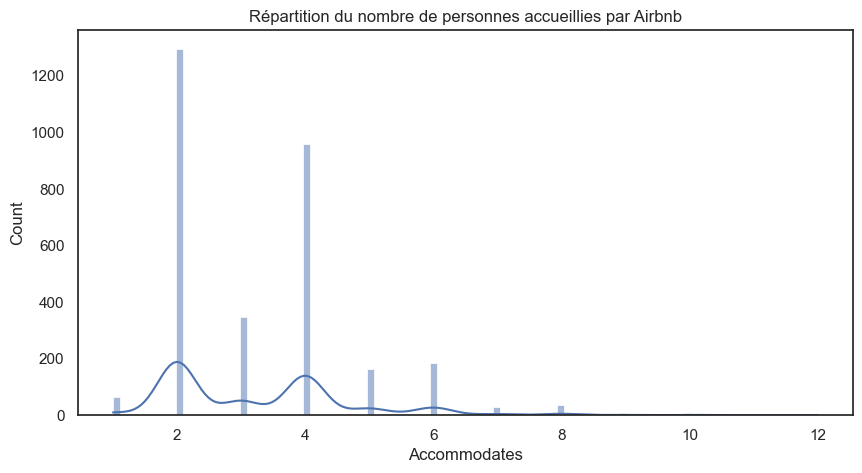

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df1['Accommodates'], kde=True, bins=int(100))
plt.title ('Répartition du nombre de personnes accueillies par Airbnb')

Text(0.5, 1.0, 'Répartition du prix par Airbnb')

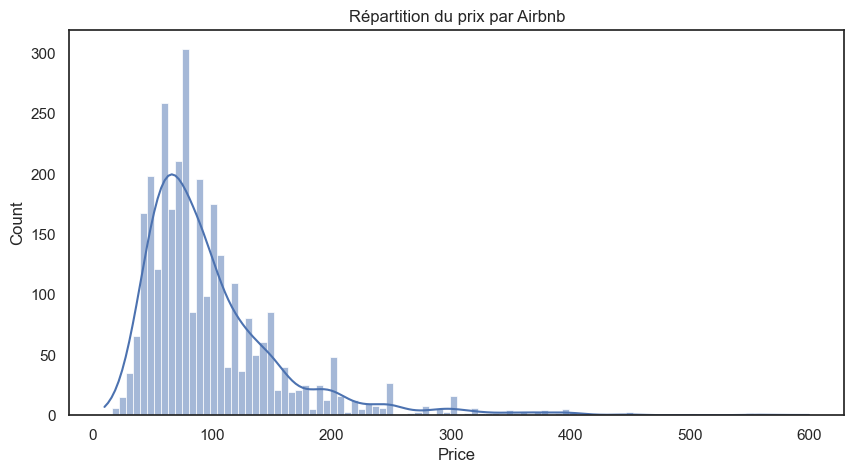

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df1['Price'], kde=True, bins=int(100))
plt.title ('Répartition du prix par Airbnb')

In [89]:
model1 = df1[(df1['Price'] < 400) & (df1['Accommodates'] <= 8)]
list(model1.columns)

['Name',
 'Space',
 'Description',
 'Neighborhood Overview',
 'Notes',
 'Transit',
 'Access',
 'Host ID',
 'Host Since',
 'Host Response Time',
 'Host Response Rate',
 'Host Total Listings Count',
 'Street',
 'Neighbourhood',
 'Neighbourhood Cleansed',
 'City',
 'Zipcode',
 'Latitude',
 'Longitude',
 'Property Type',
 'Room Type',
 'Accommodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Bed Type',
 'Amenities',
 'Square Feet',
 'Price',
 'Security Deposit',
 'Cleaning Fee',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Calendar Updated',
 'Has Availability',
 'Availability 30',
 'Availability 60',
 'Availability 90',
 'Availability 365',
 'Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value',
 'Cancellation Policy',
 'Calculated host listings count',
 'Reviews per Month',
 'Geolocation',
 'Arrondissemen

In [171]:
garde_cols = ['Price', 'Calculated host listings count','Score Annulation', 'Host Response Time', 'Arrondissement', 'Availability 30', 'Availability 365','Has Availability', 'Cleaning Fee']
drop_cols = ['Name','Space','Description','Neighborhood Overview',
 'Notes',
 'Transit',
 'Access',
 'Host ID',
 'Host Since',
 'Host Response Rate',
 'Host Total Listings Count',
 'Street',
 'Neighbourhood',
 'Host Response Time',
 'Neighbourhood Cleansed',
 'City',
 'Zipcode',
 'Latitude',
 'Longitude',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Amenities',
 'Square Feet',
 'Security Deposit',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Calendar Updated',
 'Has Availability',
 'Availability 60',
 'Availability 90',
 'Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value',
 'Cancellation Policy',
 'Reviews per Month',
 'Geolocation',
]

In [172]:
X = model1.copy()
X = X.drop(drop_cols,axis=1)
y = X['Price']


In [173]:
X.columns, y

(Index(['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
        'Cleaning Fee', 'Availability 30', 'Availability 365',
        'Calculated host listings count', 'Arrondissement', 'Score Annulation',
        'Reactivite', 'Popu Arrondissement'],
       dtype='object'),
 27573     37.0
 18230     94.0
 47736     60.0
 15438     40.0
 3414      90.0
          ...  
 4997      55.0
 30582     77.0
 25299    190.0
 1653      59.0
 18403     90.0
 Name: Price, Length: 3072, dtype: float64)

In [174]:
cols = [x.lower() for x in X.columns.tolist()]
X.columns = cols

In [175]:
df2 = X.copy()
y_copy = y.copy()

In [176]:
X = X.drop('price', axis = 1)
X.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning fee',
       'availability 30', 'availability 365', 'calculated host listings count',
       'arrondissement', 'score annulation', 'reactivite',
       'popu arrondissement'],
      dtype='object')

In [177]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [178]:
print(f' X_train shape : {X_train.shape}')
print(f' X_val shape : {X_val.shape}')
print(f' X_test shape : {X_test.shape}')

 X_train shape : (1842, 12)
 X_val shape : (615, 12)
 X_test shape : (615, 12)


## Approche par OLS

In [179]:
X_train.head()

,accommodates,bathrooms,bedrooms,beds,cleaning fee,availability 30,availability 365,calculated host listings count,arrondissement,score annulation,reactivite,popu arrondissement
41792,3,1,0.0,2.0,40.0,5,24,26,11,3,1,1494
29584,2,1,0.0,1.0,30.0,4,287,1,11,2,1,1494
25329,4,1,2.0,3.0,50.0,2,276,1,6,3,2,736
30914,2,1,0.0,1.0,45.0,2,236,34,7,3,1,583
46224,1,1,1.0,1.0,15.0,30,365,1,11,2,3,1494


In [180]:
std = StandardScaler() 
std.fit(X_train.values) 
X_train_scaled = std.transform(X_train.values)
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     225.4
Date:                Tue, 20 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:56:24   Log-Likelihood:                -9188.6
No. Observations:                1842   AIC:                         1.840e+04
Df Residuals:                    1829   BIC:                         1.847e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             96.8588      0.830    116.698      0.000      95.231      98.487
accommodates                      11.7167      1.551      7.554      0.000       8.675      14.759
bathrooms                          7.8037      0.899      8.678      0.000       6.040       9.567
bedrooms                          14.5258      1.173     12.378      0.000      12.224      16.827
beds                               1.8807      1.529      1.230      0.219      -1.119       4.880
cleaning fee                      16.6105      1.068     15.549      0.000      14.515      18.706
availability 30                    4.3532      0.957      4.549      0.000       2.476       6.230
availability 365                   3.3957      0.962      3.528      0.000       1.508       5.283
calculated host listings count     0.8057      0.905      0.890      0.373      -0.969       2.581
arrondissement                   -10.8067      0.917    -11.780      0.000     -12.606      -9.007
score annulation                   0.4263      0.883      0.483      0.629      -1.305       2.157
reactivite                        -1.4076      0.858     -1.640      0.101      -3.090       0.275
popu arrondissement               -1.4605      0.880     -1.659      0.097      -3.187       0.266
==============================================================================
Omnibus:                      524.694   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2613.199
Skew:                           1.258   Prob(JB):                         0.00
Kurtosis:                       8.265   Cond. No.                         4.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
std = StandardScaler() 
std.fit(X_train.values) 
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)
X_test_scaled = std.transform(X_test.values)

train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     225.4
Date:                Tue, 20 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:56:25   Log-Likelihood:                -9188.6
No. Observations:                1842   AIC:                         1.840e+04
Df Residuals:                    1829   BIC:                         1.847e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             96.8588      0.830    116.698      0.000      95.231      98.487
accommodates                      11.7167      1.551      7.554      0.000       8.675      14.759
bathrooms                          7.8037      0.899      8.678      0.000       6.040       9.567
bedrooms                          14.5258      1.173     12.378      0.000      12.224      16.827
beds                               1.8807      1.529      1.230      0.219      -1.119       4.880
cleaning fee                      16.6105      1.068     15.549      0.000      14.515      18.706
availability 30                    4.3532      0.957      4.549      0.000       2.476       6.230
availability 365                   3.3957      0.962      3.528      0.000       1.508       5.283
calculated host listings count     0.8057      0.905      0.890      0.373      -0.969       2.581
arrondissement                   -10.8067      0.917    -11.780      0.000     -12.606      -9.007
score annulation                   0.4263      0.883      0.483      0.629      -1.305       2.157
reactivite                        -1.4076      0.858     -1.640      0.101      -3.090       0.275
popu arrondissement               -1.4605      0.880     -1.659      0.097      -3.187       0.266
==============================================================================
Omnibus:                      524.694   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2613.199
Skew:                           1.258   Prob(JB):                         0.00
Kurtosis:                       8.265   Cond. No.                         4.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Haute p-value pour bathrooms

## Regression avec Scikit-Learn

In [182]:
def mae_score(pred, actual):
    return np.mean(np.abs(np.exp(actual) - np.exp(pred)))

In [183]:
lm = LinearRegression() 

lm.fit(X_train_scaled, y_train)

train_pred = lm.predict(X_train_scaled)
val_pred = lm.predict(X_val_scaled)

print(f'Linear Regression train R^2: {lm.score(X_train_scaled, y_train)}')
print(f'Linear Regression val R^2: {lm.score(X_val_scaled, y_val)}')

print("\nTraining MAE:", round(mean_absolute_error(y_train, train_pred),4))
print("Validation MAE:", round(mean_absolute_error(y_val, val_pred),4))

Linear Regression train R^2: 0.5965981752819283
Linear Regression val R^2: 0.5628515259328037

Training MAE: 24.8531
Validation MAE: 25.4375


In [184]:
y_train.describe()

count    1842.000000
mean       96.858849
std        55.902362
min        10.000000
25%        60.000000
50%        80.000000
75%       119.000000
max       399.000000
Name: Price, dtype: float64

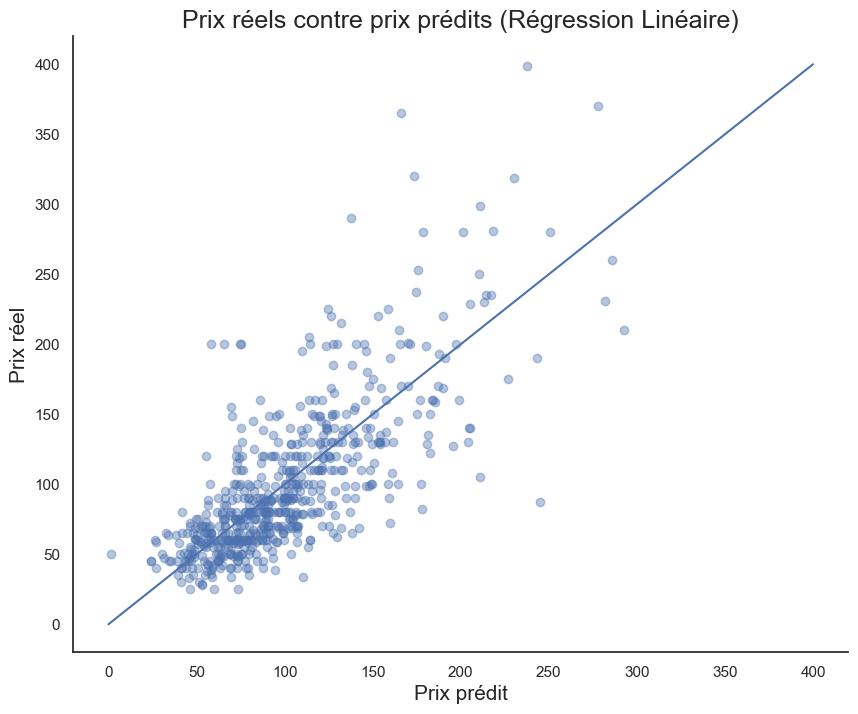

In [191]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0,400], [0,400], )
plt.scatter(val_pred, y_val, alpha=0.4)
sns.despine()
plt.ylabel('Prix réel', size=15)
plt.xlabel('Prix prédit', size=15)
plt.title('Prix réels contre prix prédits (Régression Linéaire)', size=18);
plt.savefig('actual_plot', bbox_inches ='tight', dpi = 400)

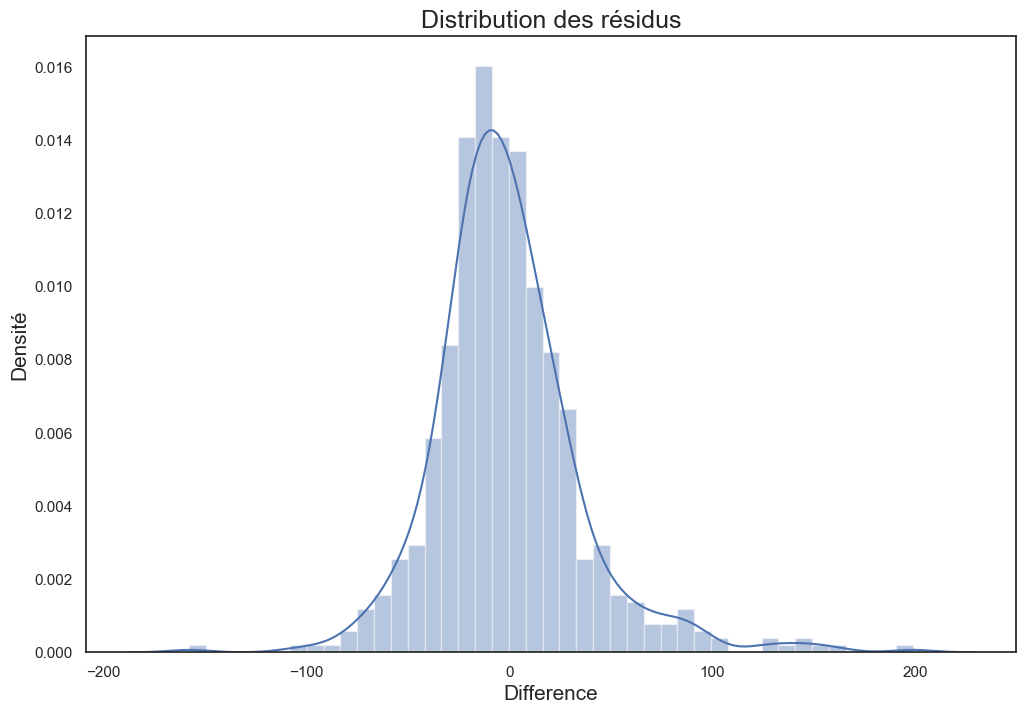

In [194]:
plt.figure(figsize=(12,8))
sns.distplot(y_val - val_pred) 
plt.title('Distribution des résidus', size = 18)
plt.xlabel('Difference', size = 15);
plt.ylabel('Densité', size = 15);
plt.savefig('residuals', bbox_inches ='tight', dpi = 400);

### Regularisation

#### Lasso

In [187]:
kf = KFold(n_splits=5, shuffle=True, random_state = 21)

alphavec = 10**np.linspace(-3,3,500)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')

train_pred = lasso_model.predict(X_train_scaled)
y_val_pred = lasso_model.predict(X_val_scaled)

print('Train MAE for LassoCV:', round(mean_absolute_error(y_train, train_pred),4))
print('Validation MAE for LassoCV:', round(mean_absolute_error(y_val, y_val_pred),4))

LassoCV alpha: 0.09637578663841088
LassoCV train R^2: 0.597
LassoCV val R^2: 0.563
Train MAE for LassoCV: 24.8333
Validation MAE for LassoCV: 25.4171


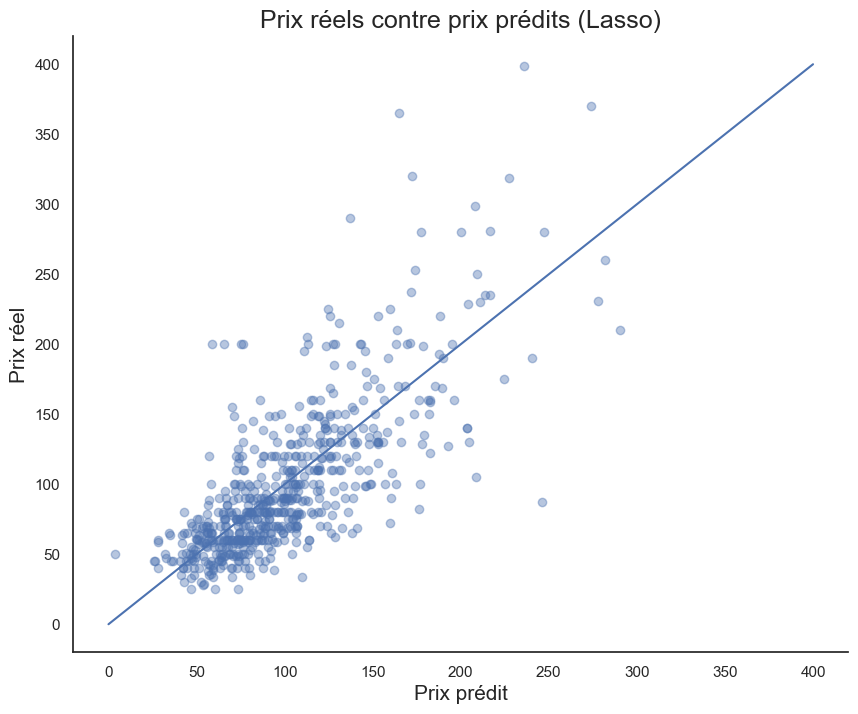

In [195]:
# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.plot([0,400], [0,400])
plt.scatter(y_val_pred, y_val, alpha=0.4)
sns.despine()
plt.ylabel('Prix réel', size=15)
plt.xlabel('Prix prédit', size=15)
plt.title('Prix réels contre prix prédits (Lasso)', size=18);
plt.savefig('actual plot', bbox_inches ='tight', dpi = 400)

#### Ridge

In [196]:
alphavec = 10**np.linspace(-3,3,500)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', ridge_model.alpha_)

print(f'LassoCV train R^2: {ridge_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV val R^2: {ridge_model.score(X_val_scaled, y_val):.3f}')

train_pred = ridge_model.predict(X_train_scaled)
y_val_pred = ridge_model.predict(X_val_scaled)

print('Train MAE for LassoCV:', round(mean_absolute_error(y_train, train_pred),4))
print('Validation MAE for LassoCV:', round(mean_absolute_error(y_val, y_val_pred),4))

LassoCV alpha: 74.08656834939568
LassoCV train R^2: 0.596
LassoCV val R^2: 0.564
Train MAE for LassoCV: 24.7751
Validation MAE for LassoCV: 25.378


#### Coefficients de la régression linéaire

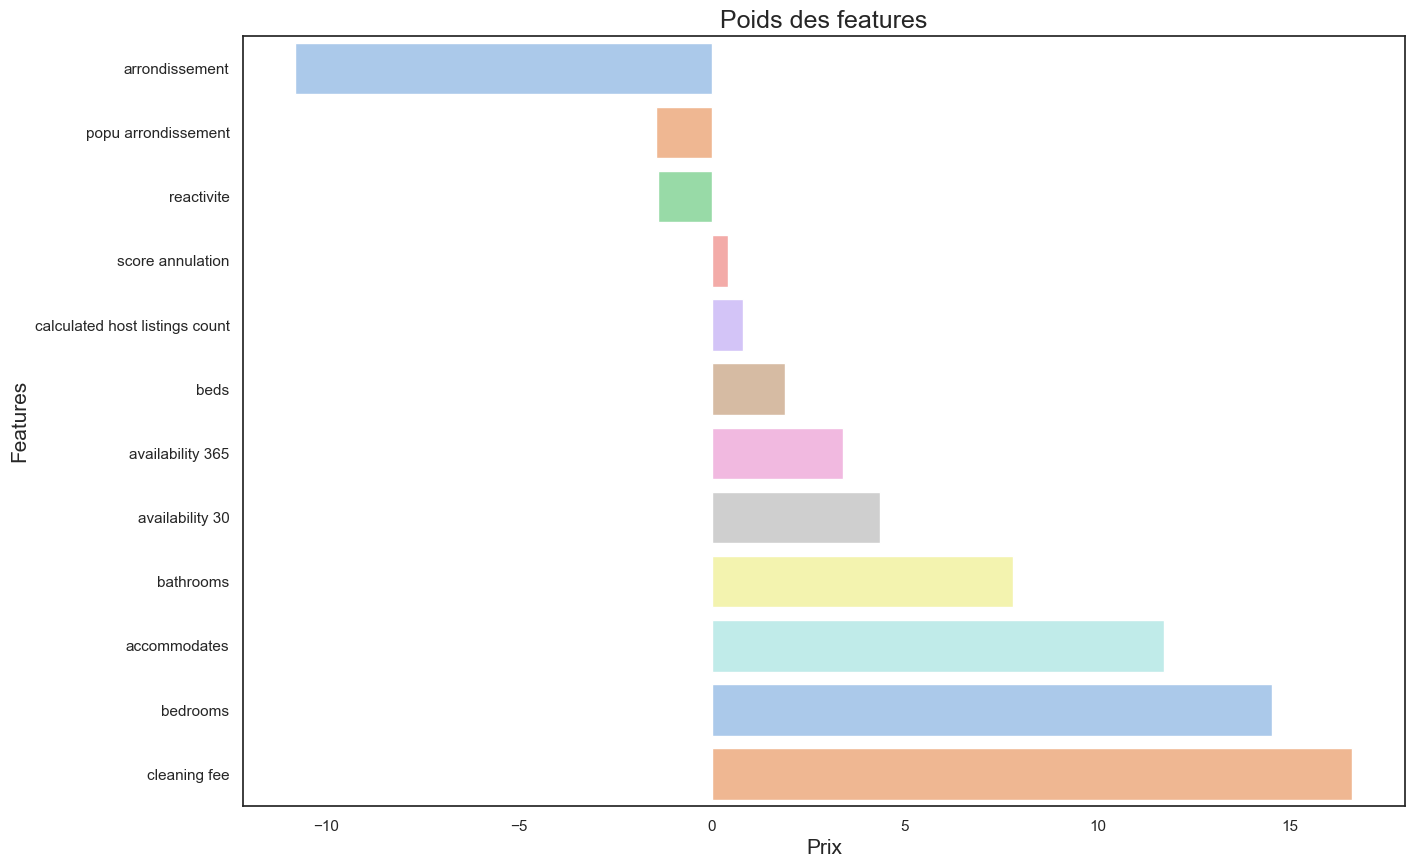

In [197]:
coef_list = sorted(list(zip(X_train.columns, lm.coef_)), key= lambda x : x[1])

x_values = [x[0] for x in coef_list]
y_values = [y[1] for y in coef_list]

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=y_values, y=x_values, palette=("pastel"))
#ax.set(xticks=xtick_list)
ax.set_title('Poids des features', size=18)
ax.set_xlabel('Prix', size=15)
ax.set_ylabel('Features', size=15)
plt.savefig('features', bbox_inches ='tight', dpi = 400)

In [111]:
x_values

['arrondissement',
 'popu arrondissement',
 'reactivite',
 'score annulation',
 'calculated host listings count',
 'beds',
 'availability 365',
 'availability 30',
 'bathrooms',
 'accommodates',
 'bedrooms',
 'cleaning fee']

In [112]:
coefs_df = pd.DataFrame(columns=['Feature', 'Coefficient'])
coefs_df['Feature'] = x_values
coefs_df['Coefficient'] = y_values
coefs_df.to_csv('lr_coefs.csv')
coefs_df

,Feature,Coefficient
0,arrondissement,-10.806666
1,popu arrondissement,-1.460548
2,reactivite,-1.407567
3,score annulation,0.426255
4,calculated host listings count,0.805694
5,beds,1.880669
6,availability 365,3.395718
7,availability 30,4.353157
8,bathrooms,7.803747
9,accommodates,11.716727


In [113]:
import matplotlib.style as style 

In [114]:
actionable_feats = ['arrondissement', 'reactivite', 'score annulation', 'beds', 'calculated host listings count', 'availability 365', 'availability 30', 'bathrooms', 'accommodates', 'bedrooms', 'cleaning fee']
coefs = coefs = sorted(list(zip(lm.coef_, X.columns)))

coefs = coefs[::-1]
improvements = [x for x in coefs if x[1] in actionable_feats]

improvements

[(16.61050652419473, 'cleaning fee'),
 (14.525815191299467, 'bedrooms'),
 (11.716727240989577, 'accommodates'),
 (7.803747287136424, 'bathrooms'),
 (4.353157294327001, 'availability 30'),
 (3.395717976474477, 'availability 365'),
 (1.8806685350984438, 'beds'),
 (0.805693547666207, 'calculated host listings count'),
 (0.42625474484006864, 'score annulation'),
 (-1.407567313405921, 'reactivite'),
 (-10.806665810143436, 'arrondissement')]

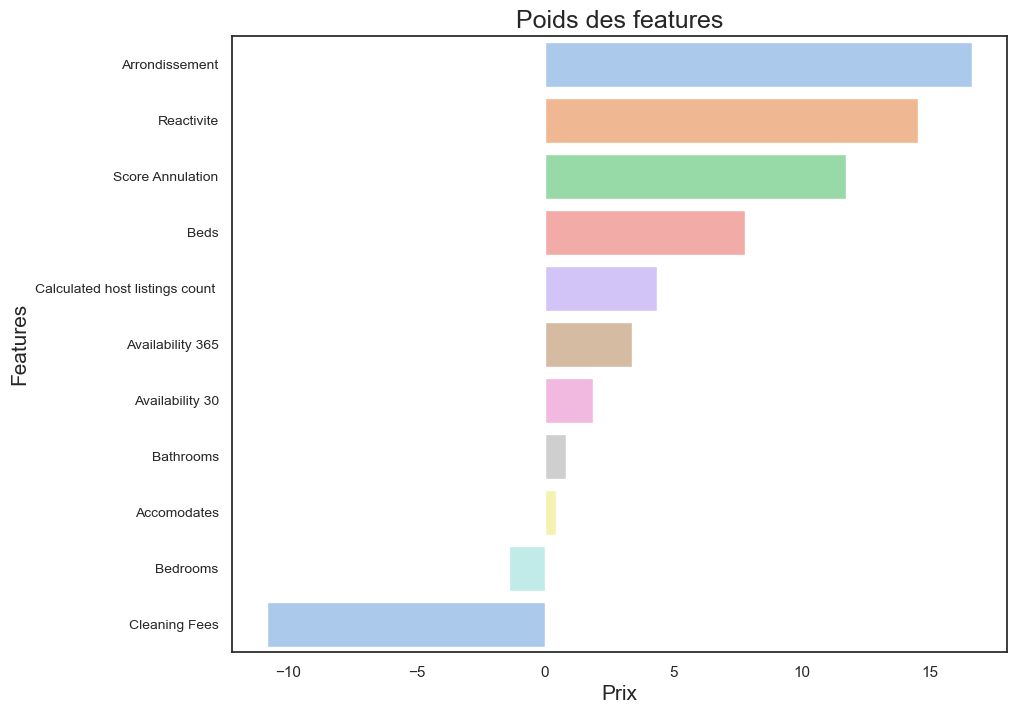

In [198]:

x_values = [x[0] for x in improvements]
y_values = [y[1] for y in improvements]

xtick_list = ['Arrondissement', 'Reactivite', 'Score Annulation', 'Beds', 'Calculated host listings count ', 'Availability 365', 'Availability 30', 'Bathrooms', 'Accomodates', 'Bedrooms', 'Cleaning Fees']
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=x_values, y=y_values, palette=("pastel"))
#ax.set(xticks=xtick_list)
ax.set_title('Poids des features', size=18)
ax.set_xlabel('Prix', size=15)
ax.set_yticklabels(xtick_list, size=10)
ax.set_ylabel('Features', size=15)
plt.savefig('features', bbox_inches ='tight', dpi = 400)

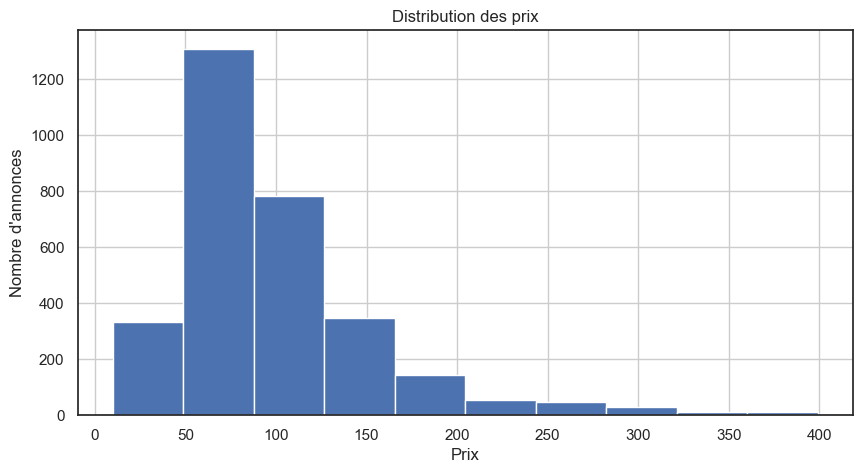

In [201]:
fig, ax = plt.subplots(figsize=(10,5)) 
model1['Price'].hist()
plt.title('Distribution des prix')
plt.xlabel('Prix')
plt.ylabel("Nombre d'annonces");

plt.savefig('Price', bbox_inches ='tight', dpi = 400)

### XGBoost

In [202]:
eval_set = [(X_val, y_val)]

In [203]:
gbm = xgb.XGBRegressor( 
                       n_estimators=10000, #arbitrary large number
                       max_depth=7,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.6
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go

xgb_reg = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mae',
                    early_stopping_rounds=20,
                    verbose=100 #gives output log as below
                   )

[0]	validation_0-mae:86.91668	validation_1-mae:88.50257
[45]	validation_0-mae:13.40938	validation_1-mae:23.78518


In [204]:
test_pred = xgb_reg.predict(X_test)
print('Test MAE:', round(mean_absolute_error(y_test, test_pred),4))

Test MAE: 24.1329


### GridSearchCV for Best Parameters

In [205]:
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'colsample_bytree':[0.5,0.75],
    'colsample_bylevel':[0.25,0.5],  
}

xgb_gridsearch = GridSearchCV(xgb.XGBRegressor(),
                           xgb_param_grid,
                           cv=5,
                           n_jobs=-1)

xgb_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [206]:
best_xgb = xgb_gridsearch.best_estimator_

In [207]:
test_pred = best_xgb.predict(X_test)
print('Test MAE:', round(mean_absolute_error(y_test, test_pred),4))

Test MAE: 24.9257


In [208]:
best_xgb

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.25, colsample_bynode=1, colsample_bytree=0.75,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [209]:
pickle.dump(best_xgb, open("best_xgb_model.pkl", "wb"))

In [210]:
feat_df = pd.DataFrame(list(zip(X_train.columns, best_xgb.feature_importances_)), 
                       columns=['Feature', 'Weight'])

In [211]:
feat_df = feat_df.sort_values(by=['Weight'], ascending=False)

In [212]:
top_10 = feat_df.head(10)

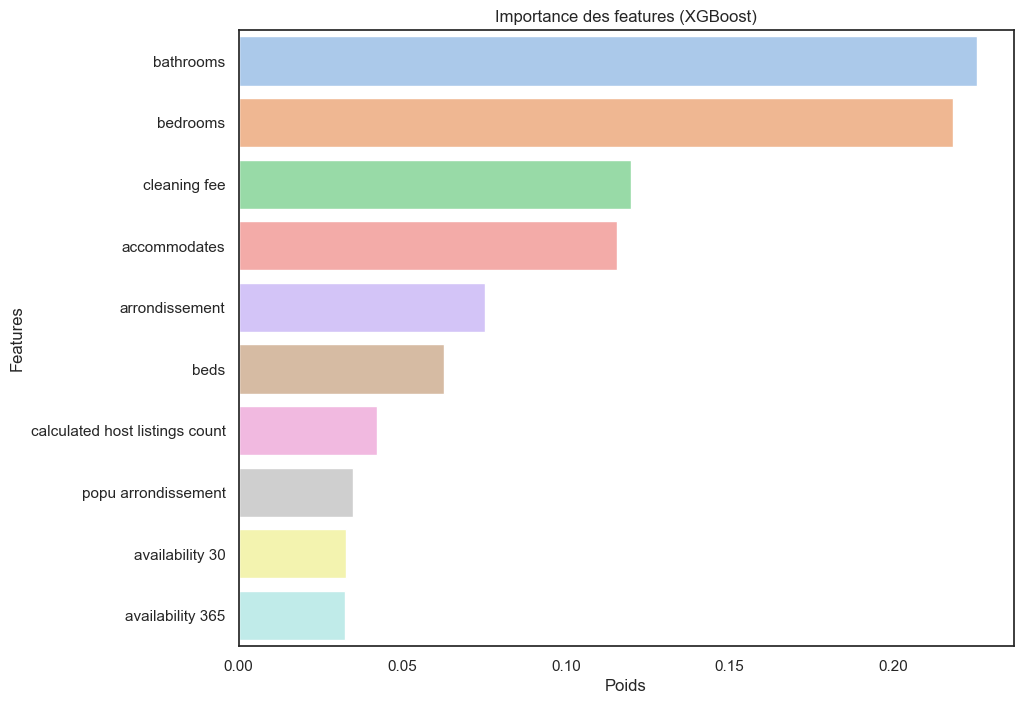

In [216]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=top_10['Weight'], y=top_10['Feature'], palette = "pastel")
plt.xlabel('Poids')
plt.ylabel('Features')
ax.set_title('Importance des features (XGBoost)');

In [236]:
shap.initjs()
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)

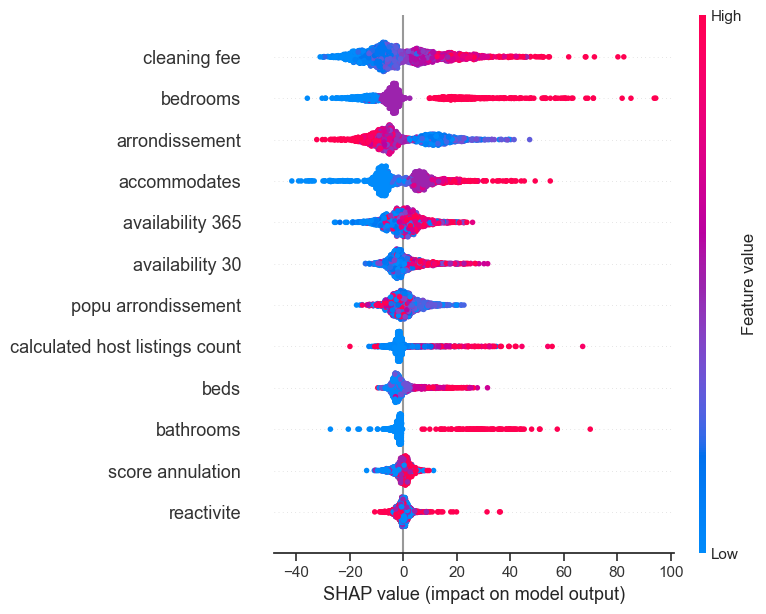

In [237]:
shap.summary_plot(shap_values, X_train,max_display=30)

In [238]:
shap.force_plot(explainer.expected_value, shap_values[113,:], X_test.iloc[10,:]) 

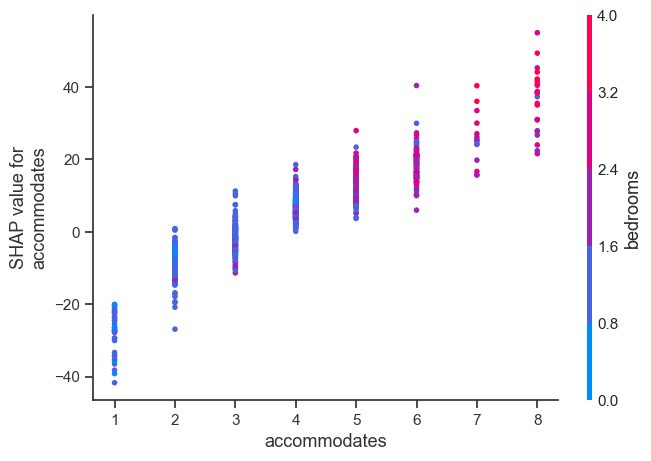

In [239]:
shap.dependence_plot("accommodates", shap_values, X_train)


In [240]:
X_display, y_display = shap.datasets.adult(display=True)

In [241]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: 96.8587875366211


In [242]:
select = range(20,50)
features = X_test.iloc[select]
features_display = X_test.iloc[select]

In [243]:
shap_values = explainer.shap_values(features)[1]

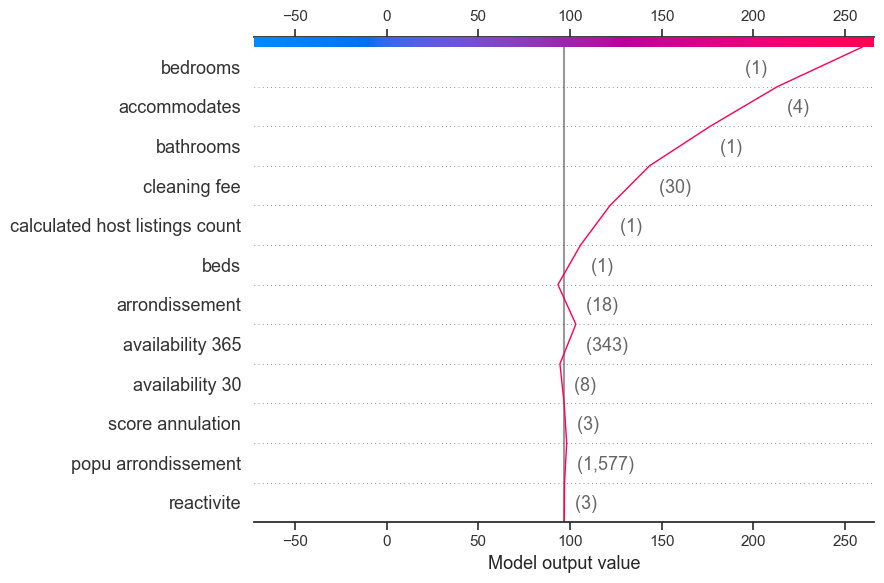

In [244]:
shap.decision_plot(expected_value, shap_values, features_display)

In [ ]:

df['Amenities'].describe()


Un premier problème apparaît lorsque l'on essaye d'exploiter la variable « amenities » : tous les équipements en questions sont groupés en format texte pour chaque observation. Ainsi, pour chaque observation, on aimerait dans un premier temps créer une variable différente pour chaque équipement. Puis, dans un second temps, créer des indicatrices pour chaque variable.

In [ ]:
#On commence par convertir la variable en format string 
df = df.astype({'Amenities' : 'string'})

In [ ]:
def indic_amenities(s):
    return len(s.split(','))

df['num_Amenities'] = df['Amenities'].apply(indic_amenities)

In [ ]:
Amenities = " ".join(list(df.Amenities))
Amenities = Amenities.replace('{', '')
Amenities = Amenities.replace('}', ',')
Amenities = Amenities.replace('"', '')
amenities_split = [x.strip() for x in Amenities.split(',')]
amenities_split = set(amenities_split)
amenities_tr = list(amenities_split)
amenities_tr

for k in amenities_tr :
    df[k] = df['Amenities'].str.contains(k).astype(int)


print(df.shape)


amenities_tr

In [ ]:
amenities_df = df.iloc[:,-10000:]
amenities_df['Price'] = df['Price']

In [ ]:
amenities_df[['Internet', 'TV', 'Cable TV', 'Heating', 'Kitchen', 'Washer', 'Elevator in building']].head()

In [ ]:
index = 1
fig = plt.figure(1, figsize=(20,50))
internet_amenities = amenities_tr[11:12]
colors = ['red','blue']
for name in internet_amenities:
    
    current_axis = fig.add_subplot(7,2,index)
    pmoy0 = df[df[name] == 0]['Price'].mean()
    pmoy1 = df[df[name] == 1]['Price'].mean()

    x = ['Sans', 'Avec']
    y = [pmoy0, pmoy1]

    ax = sns.barplot(x=x,y=y, palette=colors);
    title = 'Prix moyen du airbnb avec ou sans les chaînes de la TNT' 
    ax.set_title(title, size=15)
    ax.set_xticklabels(['Sans', 'Avec'], size=15)
    ax.set_ylabel('Prix', size = 15)
    index +=1